<a href="https://colab.research.google.com/github/rgprado/SeriesTemporais/blob/main/Series_Temporais_aula1_202201_Rodrigo_Prado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Análise de Séries Temporais
 
 **Professor**: Domingos Santos

 **Aluno**: Rodrigo Prado

**Atividade 1**:

 - selecionar 2 séries: uma financeira e uma adicional (sugestão, uma disponível no pydataset)
 - plot da média movél 
 - análise de quais componentes foram observados nas séries (Tendência, Sazonalidade e ciclos)
 - Calcularem o ACF e PACF das séries
 - analisar a série "sem_nome", identificar os componentes e defina essa série 

**Atividade 2**: para cada uma das séries:

- aplicar o KPSSTest;
- caso necessite aplique a diferenciação;
- avaliação se precisa aplicar mais diferenciações;
- aplicar o auto.arima nas duas séries selecionadas, testar a abordagem direta (sem reajustar o modelo), e one step (ajustando o arima em cada passo)



In [105]:
!pip install yfinance pydataset pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
import yfinance as yf
from pydataset import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pmdarima.arima import KPSSTest, auto_arima
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (20,10)

In [107]:
example_ma = [1,2,3,4,5,6,7,8,9,10]
ma_size=2

for i in range(ma_size, len(example_ma)):
  consider_val = example_ma[i-ma_size:i]
  print(f'valores considerados: {consider_val}, MA {np.mean(consider_val)}, valor atual {i}')

valores considerados: [1, 2], MA 1.5, valor atual 2
valores considerados: [2, 3], MA 2.5, valor atual 3
valores considerados: [3, 4], MA 3.5, valor atual 4
valores considerados: [4, 5], MA 4.5, valor atual 5
valores considerados: [5, 6], MA 5.5, valor atual 6
valores considerados: [6, 7], MA 6.5, valor atual 7
valores considerados: [7, 8], MA 7.5, valor atual 8
valores considerados: [8, 9], MA 8.5, valor atual 9


**Definição da função para cálculo da média movel**

In [108]:
def show_trend(ts, ma_size):
  to_show = pd.DataFrame()

  to_show['serie'] = ts.values[ma_size:]
  to_show['MA']  = ts.rolling(ma_size).mean().values[ma_size:]
  to_show.plot()
  plt.show()

**Definição da Funçao DIFF**


In [109]:
def difference(ts, interval=1):
  diff = list()

  for t in range(interval, ts.shape[0]):
    value = ts[t] - ts[t - interval]
    diff.append(value)


  return pd.Series(diff)

**Definição da função para busca de ações**


In [110]:
def get_yfinance(id_name):
  df = yf.Ticker(id_name)
  return  df.history(period="max")

**Definição da função para predict do modelo ARIMA**




In [111]:
def arima_fit_predict(ts, m, test_size):
  ts_train = ts[0:-test_size]
  ts_test = ts[-test_size:]

  print(f'training shape {ts_train.shape}')
  print(f'test shape {ts_test.shape}')

  model = auto_arima(ts_train.values, # X=None,
                    start_p=2, d=None, start_q=2, 
                    max_p=5, max_d=2, max_q=5, start_P=1, D=None,
                    start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=m, trace=True, maxiter=10)
 
  direct_prev = model.predict(test_size)

  prevs_1_step = []
  for i in tqdm(ts_test):
    prevs_1_step.append(model.predict(1)[0])
    model.update(i)

  df_result = pd.DataFrame({
                          'arima_direct': direct_prev ,
                          'arima_1step': prevs_1_step,
                          'real': ts_test.values
                          })
  return df_result

**Definição da função para predict com horizonte do modelo ARIMA**

In [112]:
def arima_horizon_fit_predict(ts, m, test_size, horizon):
  horizon = horizon

  ts_train = ts[0:-(test_size+(horizon-1))]
  ts_test = ts[-(test_size+(horizon-1)):]

  print(f'training shape {ts_train.shape}')
  print(f'test shape {ts_test.shape}')
  model = auto_arima(ts_train.values, # X=None,
                      start_p=2, d=None, start_q=2, 
                      max_p=5, max_d=2, max_q=5, start_P=1, D=None,
                      start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=m, trace=True, maxiter=10)

  prevs_step = []
  count = 0
  for i in tqdm(ts_test):
    print(f'fim do treino {count+ts_train.shape[0]}')
    prevs_step.append(model.predict(horizon)[horizon-1])
    model.update(i)
    count= count  +1

  df_result = pd.DataFrame({
                          f'arima_{horizon}step': prevs_step[0:-(horizon-1)],
                          'real': ts[-test_size:].values
                          })
  return df_result

##Definição de função para plot da série e diferentes previsões

In [113]:
def plot_predict(ts, ts_predict, test_size):
  TEST_SIZE = test_size
  data = ts
  train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
  x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
  print(train.shape, x_train.shape, test.shape, x_test.shape)

  arima_direct = ts_predict['arima_direct']
  arima_1step = ts_predict['arima_1step']
  real = ts_predict['real']
  arima_10step = ts_predict['arima_10step']

  fig, ax = plt.subplots(1, 1, figsize=(25, 7))
  ax.plot(x_train, train)
  ax.plot(x_test, arima_direct)
  ax.plot(x_test, arima_1step)
  ax.plot(x_test, arima_10step)
  ax.plot(x_test, real)
  plt.show()

## Definição da funções para cálculo do erro##

In [114]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):

    return mean_square_error(y_true, y_pred)**0.5


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):
    
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    
    return {'MSE': mean_square_error(y_true, y_pred),
            'RMSE':root_mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}


##Função para criação da windowing##

In [115]:
def create_windowing(ts, lag_size):
  df_final = None

  for i in range(0, (lag_size+1)):
    serie = ts.shift(i)
    if i==0:
      serie.name = 'actual'
    else:
      serie.name = f'lag_{i}'

    df_final = pd.concat([serie , df_final], axis=1)

  return df_final.dropna()

## Análise Financeira - Fechamento das ações da Berkshire Hathaway##

In [116]:
df_berkshire = get_yfinance('BRK-A')

In [117]:
df_berkshire

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-03-17 00:00:00-05:00,290.0,310.00000,290.0,290.00000,10000,0.0,0.0
1980-03-18 00:00:00-05:00,290.0,290.00000,290.0,290.00000,0,0.0,0.0
1980-03-19 00:00:00-05:00,290.0,310.00000,290.0,290.00000,20000,0.0,0.0
1980-03-20 00:00:00-05:00,290.0,290.00000,290.0,290.00000,0,0.0,0.0
1980-03-21 00:00:00-05:00,290.0,290.00000,290.0,290.00000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-01-25 00:00:00-05:00,468228.0,472800.00000,464975.0,471657.00000,3800,0.0,0.0
2023-01-26 00:00:00-05:00,474037.0,475336.00000,468469.0,469960.00000,3900,0.0,0.0
2023-01-27 00:00:00-05:00,468410.0,472885.00000,466576.0,470000.00000,4200,0.0,0.0


**Análise:**

No gráfico de fechamento das ações da Berkshire Hathaway podemos observar uma tendência positiva na valorização das ações.

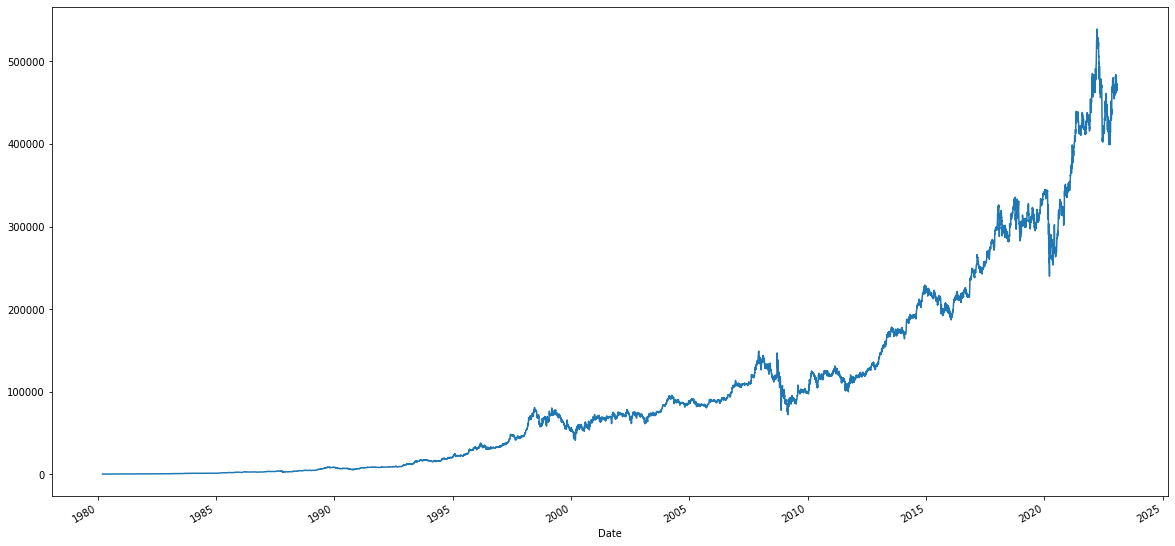

In [118]:
df_berkshire['Close'].plot()

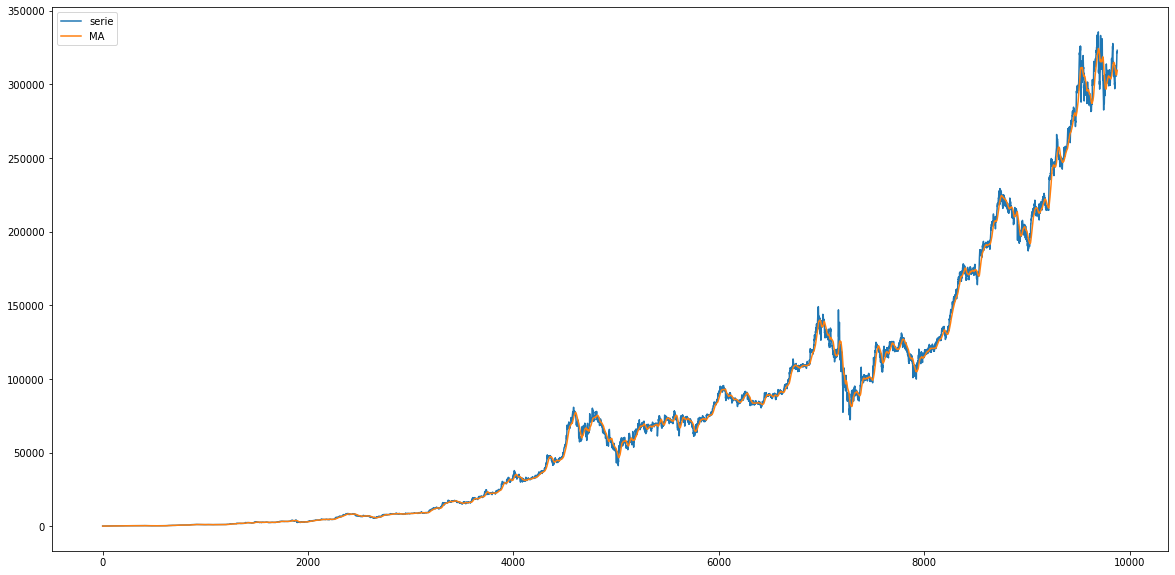

In [119]:
ts_berkshire = df_berkshire['Close'].iloc[:-900]
ma_size=30
show_trend(ts_berkshire, ma_size)

**Análise**:

No gráfico de correlação acumulada, aparentemente existe uma correlação muito forte entre os dias, analisado com um lag de 20.

Mas fazendo a análise parcial da correlação, podemos ver que o gráfico apresenta uma característica "Random Walk", correlação forte com t-1, porém o restante bastante variado e com média próxima de zero.

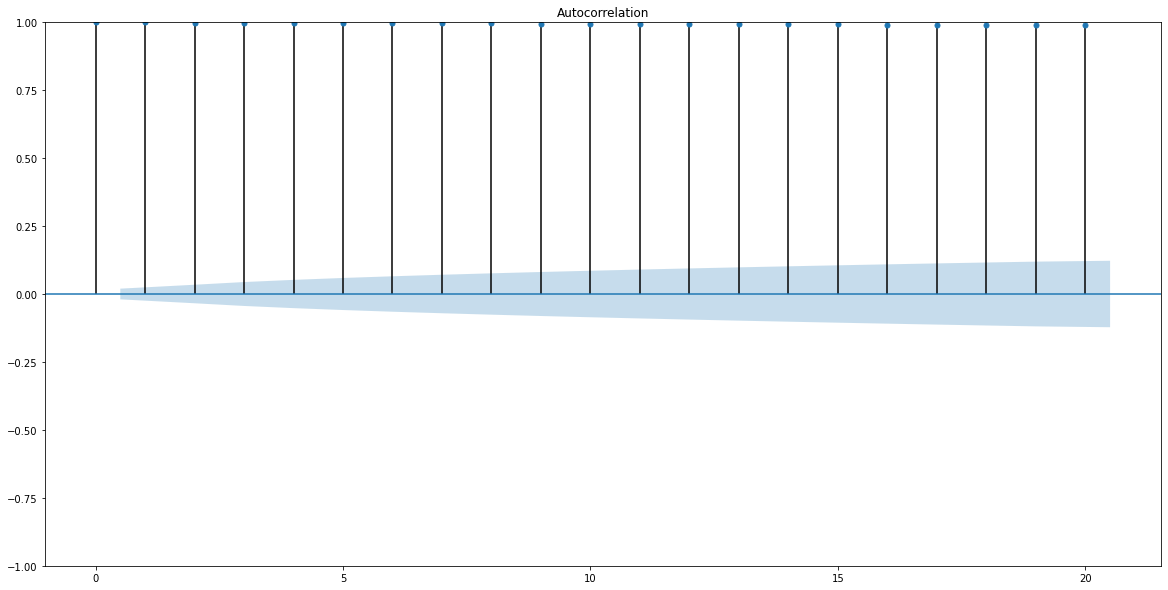

In [120]:
sm.graphics.tsa.plot_acf(ts_berkshire.values.squeeze(), lags=20)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


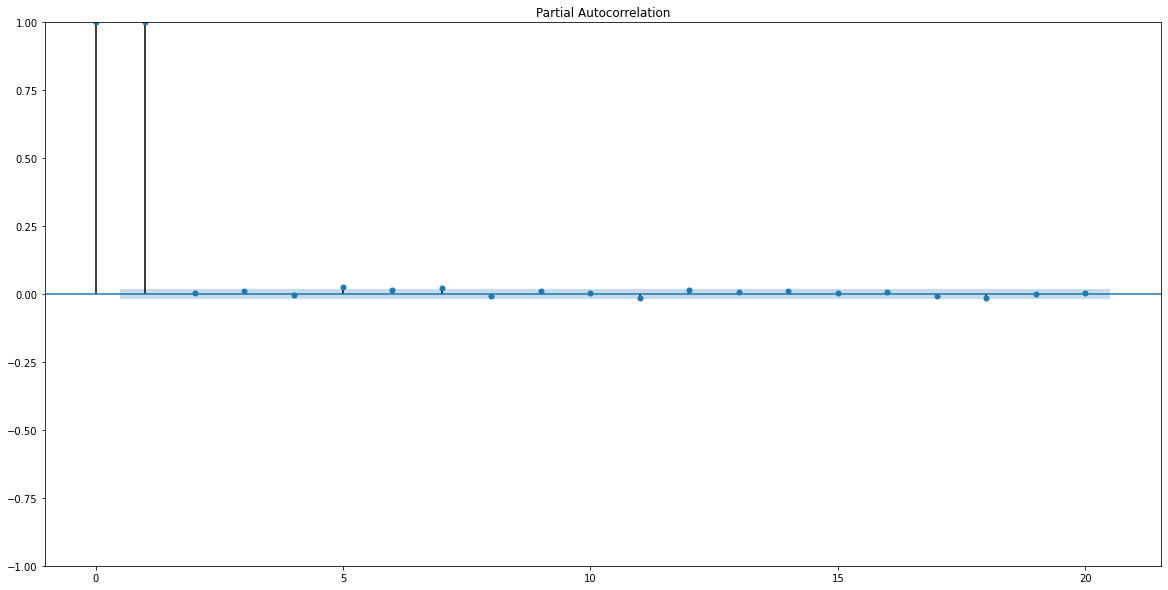

In [121]:
sm.graphics.tsa.plot_pacf(ts_berkshire.values.squeeze(), lags=20)

plt.show()

**Análise com função KPSSTest - Berkshire Hathaway**

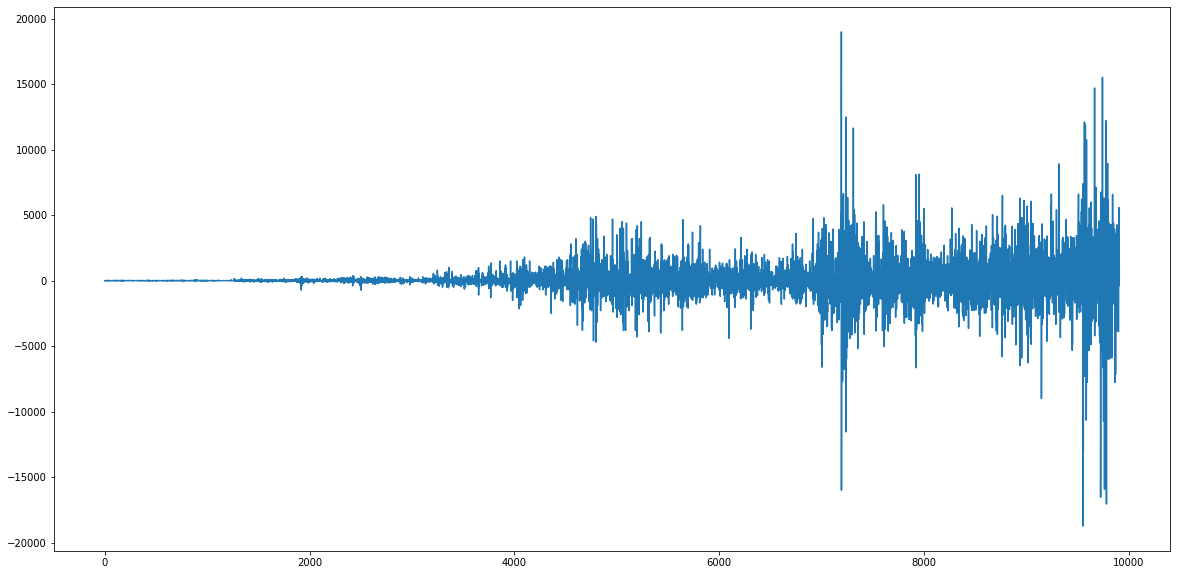

In [122]:
diff_finance = difference(ts_berkshire) # ou ts.diff()
diff_finance.plot()
plt.show()

In [123]:
kps = KPSSTest()
kps.should_diff(df_berkshire['Close'])

(0.01, True)

**Análise**

Plot do ACF para o primeiro diff da série. 

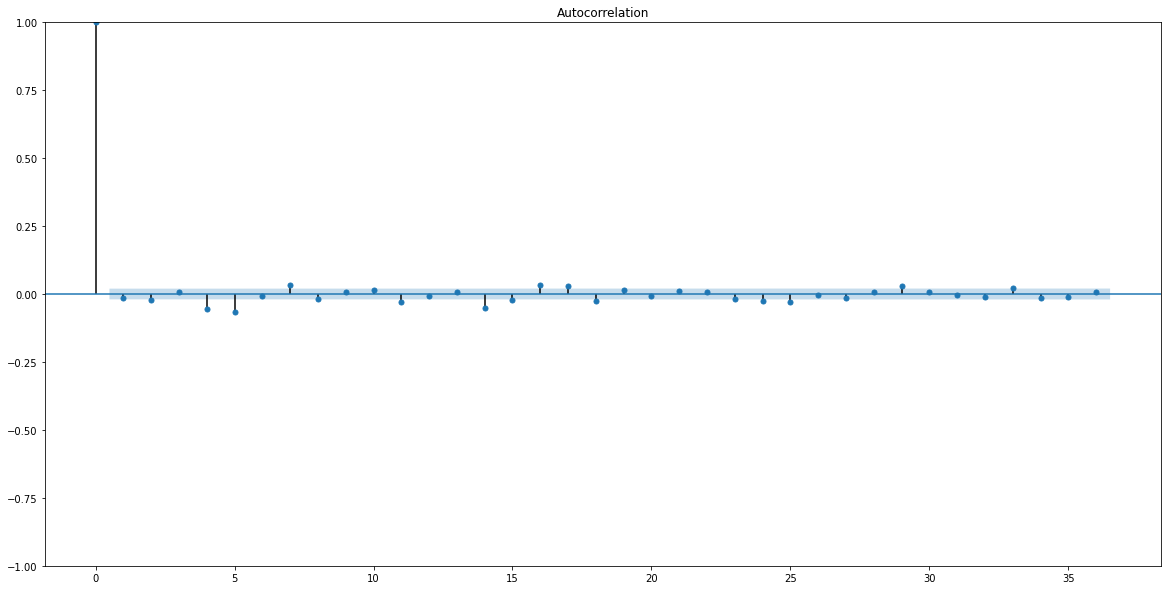

In [124]:
sm.graphics.tsa.plot_acf(diff_finance, lags=36)
plt.show()

**Análise**

Plot do PACF para o primeiro diff da série. 

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


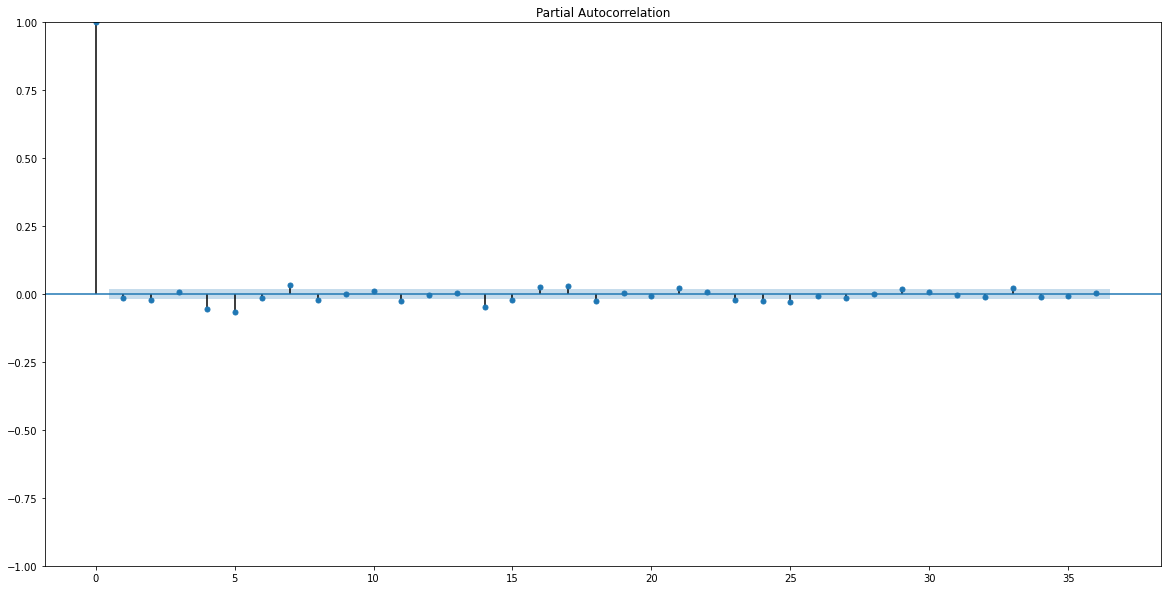

In [125]:
sm.graphics.tsa.plot_pacf(diff_finance, lags=36)
plt.show()

**Análise**

Verificando se é necessário fazer mais um diff na série. O retorno indica que sim.

In [126]:
kps.should_diff(diff_finance)

(0.022060102279158333, True)

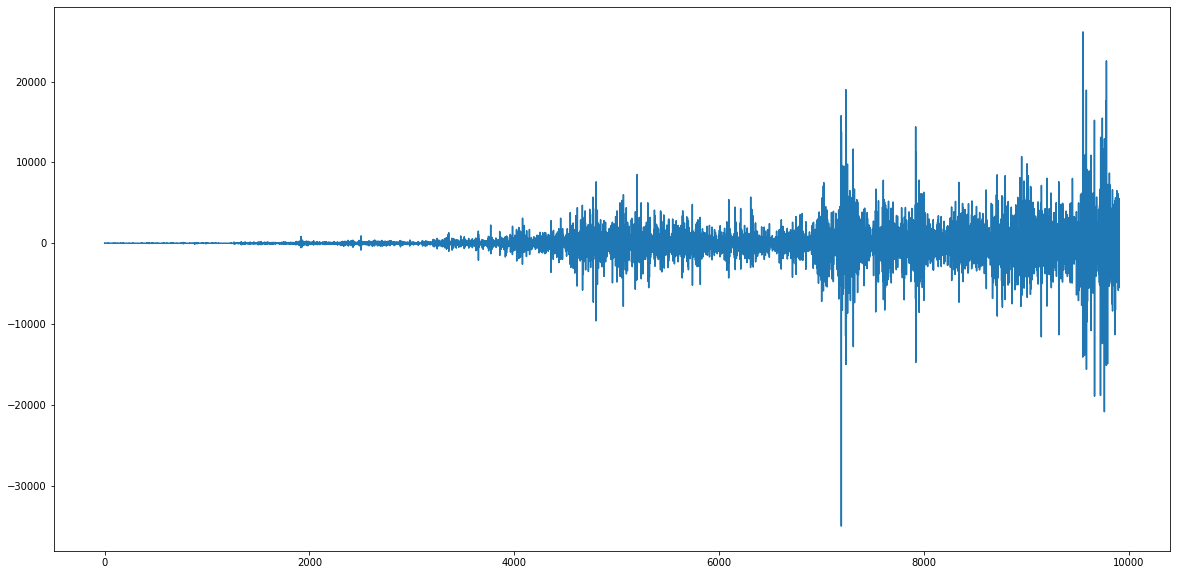

In [127]:
diff_finance2 = difference(diff_finance) # ou ts.diff()
diff_finance2.plot()
plt.show()

**Análise gráfica**

Plot do ACF e PACF da segunda diferença

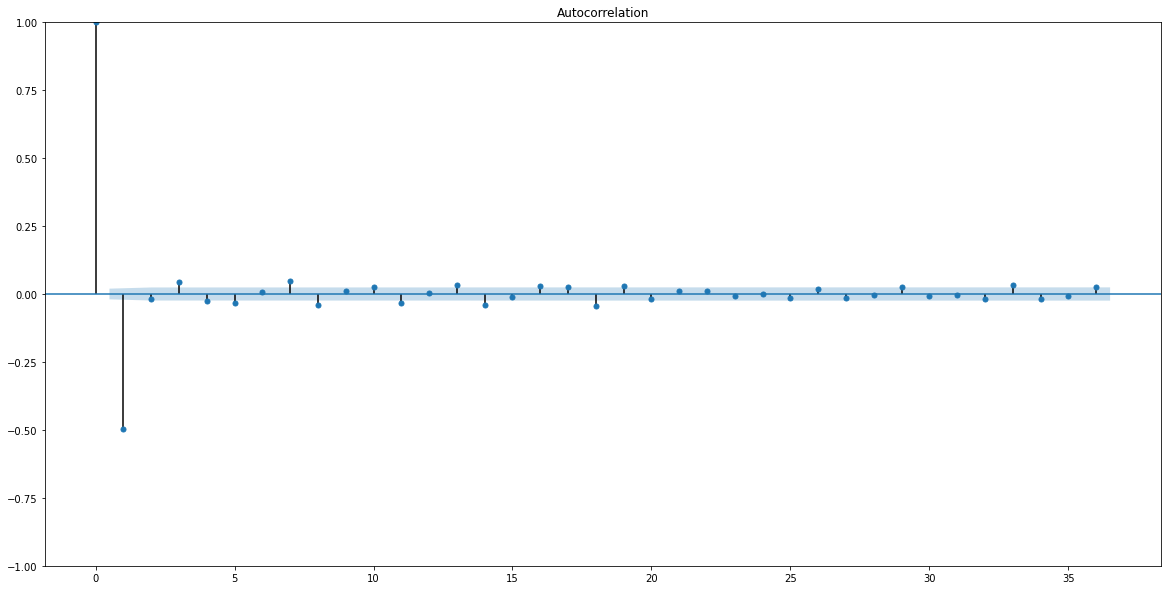

In [128]:
sm.graphics.tsa.plot_acf(diff_finance2, lags=36)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


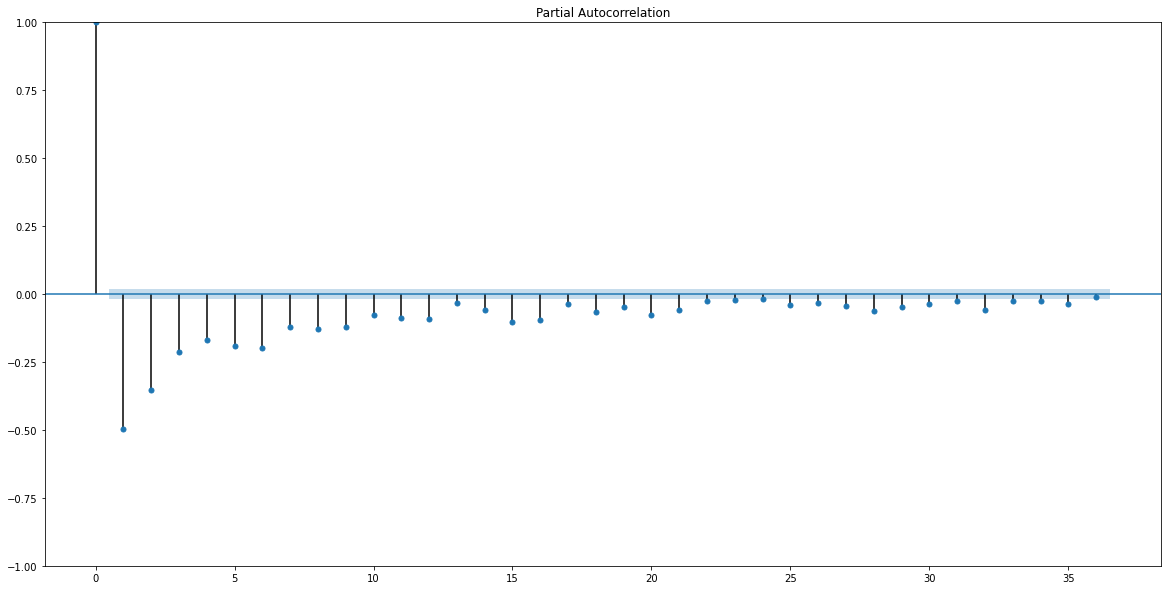

In [129]:
sm.graphics.tsa.plot_pacf(diff_finance2, lags=36)
plt.show()

**Análise**

Novo KPSSTest, agora retorno falso.

De acordo com a função de KPSSTest, o dados de fechamento da Berkshire precisariam da função diff e mesmo depois da primeira passagem, ainda seria necessário fazer mais uma differença.

In [130]:
kps.should_diff(diff_finance2)

(0.1, False)

##Criação do modelo com auto_arima##

Para criação do modelo não foram utilizados todos os dados da série temporal, somente os últimos 900.

In [131]:
auto_arima(ts_berkshire, # X=None,
           start_p=2, d=None, start_q=2, 
           max_p=5, max_d=2, max_q=5, start_P=1, D=None,
           start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, trace=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=2.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=177809.781, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=175003.338, Time=0.35 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=1.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=173698.092, Time=0.55 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=173237.552, Time=0.66 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=172951.376, Time=0.97 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=172581.270, Time=1.67 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=171092.218, Time=5.97 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=171121.383, Time=5.66 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=inf, Time=5.91 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=inf, Time=4.51 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=171094.579, Time=7.13 sec

Best model:  ARIMA(5,2,1)(0,0,0)[0]          
Total fit time: 36.703 seconds


ARIMA(maxiter=10, order=(5, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

##Fazendo predict de 1 step com auto_arima##

In [132]:
df_arima_berkshire = arima_fit_predict(ts_berkshire, 1, 90)

training shape (9821,)
test shape (90,)
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.98 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=175965.853, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=173208.986, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.93 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=171896.324, Time=0.44 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=171453.216, Time=0.55 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=171159.947, Time=0.70 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=170772.967, Time=0.87 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=169298.312, Time=2.82 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=169260.168, Time=2.53 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=169373.752, Time=1.84 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=inf, Time=2.39 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=2.15 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=inf, Time=3.21 sec


100%|██████████| 90/90 [02:39<00:00,  1.77s/it]


##Fazendo predict de 10 steps (horizon) com auto_arima##

In [133]:
arima_hsteps = arima_horizon_fit_predict(ts_berkshire, 1, 90, 10)
df_arima_berkshire['arima_10step'] = arima_hsteps['arima_10step'].values

training shape (9812,)
test shape (99,)
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.84 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=175745.749, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=172989.988, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=1.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=171687.494, Time=0.48 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=171252.376, Time=0.55 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=170971.399, Time=0.74 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=170577.963, Time=0.88 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=169105.361, Time=2.82 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=169074.831, Time=2.80 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=169176.560, Time=1.84 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=inf, Time=2.41 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=2.09 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=inf, Time=2.92 sec


  0%|          | 0/99 [00:00<?, ?it/s]

fim do treino 9812


  1%|          | 1/99 [00:02<04:04,  2.49s/it]

fim do treino 9813


  2%|▏         | 2/99 [00:04<03:07,  1.93s/it]

fim do treino 9814


  3%|▎         | 3/99 [00:05<02:48,  1.75s/it]

fim do treino 9815


  4%|▍         | 4/99 [00:07<02:39,  1.68s/it]

fim do treino 9816


  5%|▌         | 5/99 [00:08<02:33,  1.63s/it]

fim do treino 9817


  6%|▌         | 6/99 [00:10<02:28,  1.60s/it]

fim do treino 9818


  7%|▋         | 7/99 [00:11<02:25,  1.58s/it]

fim do treino 9819


  8%|▊         | 8/99 [00:13<02:23,  1.57s/it]

fim do treino 9820


  9%|▉         | 9/99 [00:15<02:26,  1.63s/it]

fim do treino 9821


 10%|█         | 10/99 [00:16<02:29,  1.68s/it]

fim do treino 9822


 11%|█         | 11/99 [00:18<02:25,  1.66s/it]

fim do treino 9823


 12%|█▏        | 12/99 [00:20<02:23,  1.65s/it]

fim do treino 9824


 13%|█▎        | 13/99 [00:21<02:21,  1.65s/it]

fim do treino 9825


 14%|█▍        | 14/99 [00:23<02:19,  1.64s/it]

fim do treino 9826


 15%|█▌        | 15/99 [00:24<02:17,  1.64s/it]

fim do treino 9827


 16%|█▌        | 16/99 [00:26<02:16,  1.64s/it]

fim do treino 9828


 17%|█▋        | 17/99 [00:28<02:13,  1.63s/it]

fim do treino 9829


 18%|█▊        | 18/99 [00:29<02:14,  1.66s/it]

fim do treino 9830


 19%|█▉        | 19/99 [00:31<02:11,  1.65s/it]

fim do treino 9831


 20%|██        | 20/99 [00:33<02:10,  1.65s/it]

fim do treino 9832


 21%|██        | 21/99 [00:35<02:14,  1.72s/it]

fim do treino 9833


 22%|██▏       | 22/99 [00:36<02:10,  1.69s/it]

fim do treino 9834


 23%|██▎       | 23/99 [00:38<02:08,  1.69s/it]

fim do treino 9835


 24%|██▍       | 24/99 [00:40<02:09,  1.72s/it]

fim do treino 9836


 25%|██▌       | 25/99 [00:42<02:13,  1.81s/it]

fim do treino 9837


 26%|██▋       | 26/99 [00:44<02:14,  1.84s/it]

fim do treino 9838


 27%|██▋       | 27/99 [00:45<02:09,  1.80s/it]

fim do treino 9839


 28%|██▊       | 28/99 [00:47<02:04,  1.76s/it]

fim do treino 9840


 29%|██▉       | 29/99 [00:49<02:05,  1.79s/it]

fim do treino 9841


 30%|███       | 30/99 [00:51<02:05,  1.82s/it]

fim do treino 9842


 31%|███▏      | 31/99 [00:53<02:04,  1.83s/it]

fim do treino 9843


 32%|███▏      | 32/99 [00:55<02:03,  1.85s/it]

fim do treino 9844


 33%|███▎      | 33/99 [00:56<01:59,  1.82s/it]

fim do treino 9845


 34%|███▍      | 34/99 [00:58<01:55,  1.78s/it]

fim do treino 9846


 35%|███▌      | 35/99 [01:00<01:53,  1.77s/it]

fim do treino 9847


 36%|███▋      | 36/99 [01:01<01:50,  1.76s/it]

fim do treino 9848


 37%|███▋      | 37/99 [01:03<01:53,  1.82s/it]

fim do treino 9849


 38%|███▊      | 38/99 [01:05<01:49,  1.79s/it]

fim do treino 9850


 39%|███▉      | 39/99 [01:07<01:49,  1.82s/it]

fim do treino 9851


 40%|████      | 40/99 [01:09<01:48,  1.84s/it]

fim do treino 9852


 41%|████▏     | 41/99 [01:11<01:48,  1.87s/it]

fim do treino 9853


 42%|████▏     | 42/99 [01:13<01:43,  1.82s/it]

fim do treino 9854


 43%|████▎     | 43/99 [01:15<01:46,  1.90s/it]

fim do treino 9855


 44%|████▍     | 44/99 [01:16<01:41,  1.85s/it]

fim do treino 9856


 45%|████▌     | 45/99 [01:18<01:41,  1.88s/it]

fim do treino 9857


 46%|████▋     | 46/99 [01:20<01:41,  1.92s/it]

fim do treino 9858


 47%|████▋     | 47/99 [01:22<01:40,  1.93s/it]

fim do treino 9859


 48%|████▊     | 48/99 [01:24<01:35,  1.87s/it]

fim do treino 9860


 49%|████▉     | 49/99 [01:26<01:31,  1.83s/it]

fim do treino 9861


 51%|█████     | 50/99 [01:28<01:28,  1.82s/it]

fim do treino 9862


 52%|█████▏    | 51/99 [01:29<01:27,  1.82s/it]

fim do treino 9863


 53%|█████▎    | 52/99 [01:31<01:24,  1.79s/it]

fim do treino 9864


 54%|█████▎    | 53/99 [01:33<01:21,  1.78s/it]

fim do treino 9865


 55%|█████▍    | 54/99 [01:35<01:19,  1.77s/it]

fim do treino 9866


 56%|█████▌    | 55/99 [01:37<01:20,  1.83s/it]

fim do treino 9867


 57%|█████▋    | 56/99 [01:39<01:19,  1.86s/it]

fim do treino 9868


 58%|█████▊    | 57/99 [01:40<01:19,  1.90s/it]

fim do treino 9869


 59%|█████▊    | 58/99 [01:42<01:15,  1.85s/it]

fim do treino 9870


 60%|█████▉    | 59/99 [01:44<01:12,  1.82s/it]

fim do treino 9871


 61%|██████    | 60/99 [01:46<01:11,  1.83s/it]

fim do treino 9872


 62%|██████▏   | 61/99 [01:48<01:08,  1.80s/it]

fim do treino 9873


 63%|██████▎   | 62/99 [01:49<01:05,  1.78s/it]

fim do treino 9874


 64%|██████▎   | 63/99 [01:51<01:04,  1.79s/it]

fim do treino 9875


 65%|██████▍   | 64/99 [01:53<01:02,  1.78s/it]

fim do treino 9876


 66%|██████▌   | 65/99 [01:55<01:00,  1.78s/it]

fim do treino 9877


 67%|██████▋   | 66/99 [01:57<01:02,  1.90s/it]

fim do treino 9878


 68%|██████▊   | 67/99 [01:59<01:01,  1.93s/it]

fim do treino 9879


 69%|██████▊   | 68/99 [02:01<00:59,  1.92s/it]

fim do treino 9880


 70%|██████▉   | 69/99 [02:03<00:56,  1.90s/it]

fim do treino 9881


 71%|███████   | 70/99 [02:04<00:54,  1.88s/it]

fim do treino 9882


 72%|███████▏  | 71/99 [02:06<00:52,  1.88s/it]

fim do treino 9883


 73%|███████▎  | 72/99 [02:08<00:52,  1.93s/it]

fim do treino 9884


 74%|███████▎  | 73/99 [02:10<00:51,  1.96s/it]

fim do treino 9885


 75%|███████▍  | 74/99 [02:12<00:49,  1.97s/it]

fim do treino 9886


 76%|███████▌  | 75/99 [02:14<00:47,  1.97s/it]

fim do treino 9887


 77%|███████▋  | 76/99 [02:16<00:44,  1.92s/it]

fim do treino 9888


 78%|███████▊  | 77/99 [02:18<00:42,  1.95s/it]

fim do treino 9889


 79%|███████▉  | 78/99 [02:20<00:41,  1.99s/it]

fim do treino 9890


 80%|███████▉  | 79/99 [02:22<00:39,  1.97s/it]

fim do treino 9891


 81%|████████  | 80/99 [02:24<00:36,  1.94s/it]

fim do treino 9892


 82%|████████▏ | 81/99 [02:26<00:34,  1.91s/it]

fim do treino 9893


 83%|████████▎ | 82/99 [02:28<00:32,  1.91s/it]

fim do treino 9894


 84%|████████▍ | 83/99 [02:30<00:30,  1.93s/it]

fim do treino 9895


 85%|████████▍ | 84/99 [02:32<00:29,  1.98s/it]

fim do treino 9896


 86%|████████▌ | 85/99 [02:34<00:27,  1.99s/it]

fim do treino 9897


 87%|████████▋ | 86/99 [02:36<00:26,  2.01s/it]

fim do treino 9898


 88%|████████▊ | 87/99 [02:38<00:23,  1.96s/it]

fim do treino 9899


 89%|████████▉ | 88/99 [02:40<00:21,  1.93s/it]

fim do treino 9900


 90%|████████▉ | 89/99 [02:42<00:19,  1.92s/it]

fim do treino 9901


 91%|█████████ | 90/99 [02:43<00:17,  1.90s/it]

fim do treino 9902


 92%|█████████▏| 91/99 [02:45<00:15,  1.88s/it]

fim do treino 9903


 93%|█████████▎| 92/99 [02:47<00:13,  1.87s/it]

fim do treino 9904


 94%|█████████▍| 93/99 [02:49<00:11,  1.85s/it]

fim do treino 9905


 95%|█████████▍| 94/99 [02:51<00:09,  1.94s/it]

fim do treino 9906


 96%|█████████▌| 95/99 [02:53<00:07,  1.91s/it]

fim do treino 9907


 97%|█████████▋| 96/99 [02:55<00:05,  1.89s/it]

fim do treino 9908


 98%|█████████▊| 97/99 [02:57<00:03,  1.88s/it]

fim do treino 9909


 99%|█████████▉| 98/99 [02:58<00:01,  1.89s/it]

fim do treino 9910


100%|██████████| 99/99 [03:00<00:00,  1.83s/it]


## Plot das previsões de 1 step, 10 steps, direct e real

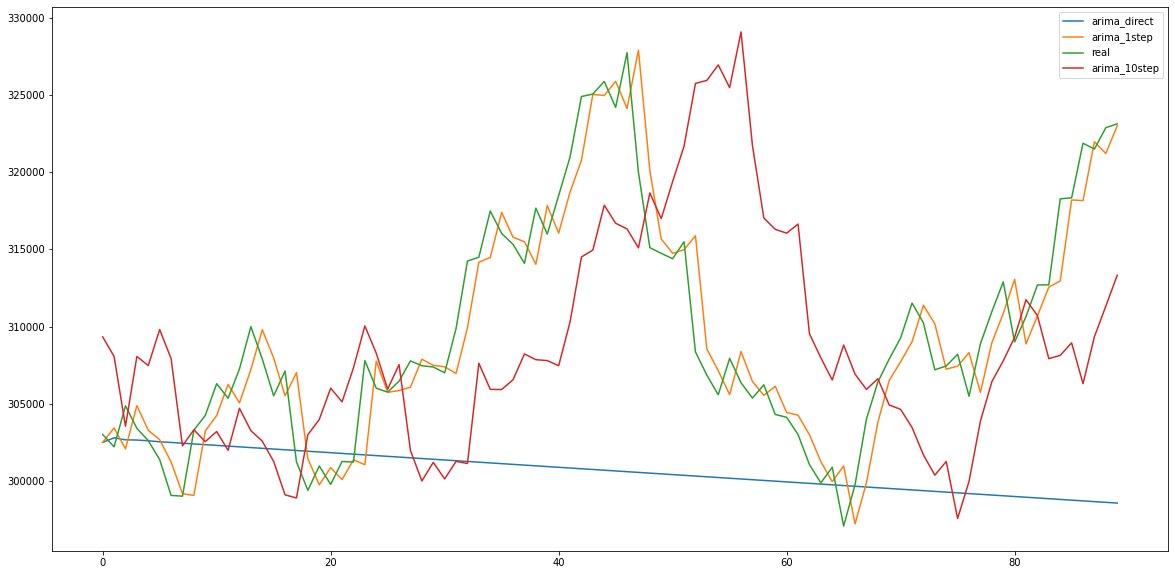

In [134]:
df_arima_berkshire.plot()

In [135]:
df_arima_berkshire.head()

,arima_direct,arima_1step,real,arima_10step
0,302486.324000,302486.324000,303000.0,309333.669037
1,302784.319642,303431.013824,302200.0,308064.981179
2,302655.556258,302068.500908,304860.0,303536.673791
3,302640.227451,304871.405078,303400.0,308059.498668
4,302594.164134,303272.284506,302600.0,307473.593270


## Visão das previsões junto com os dados reais da Berkshire Hathaway

A visão tem relação somente com os últimos 3 anos

O tamanho utilizado para testes foi 90

(9821,) (9821,) (90,) (90,)


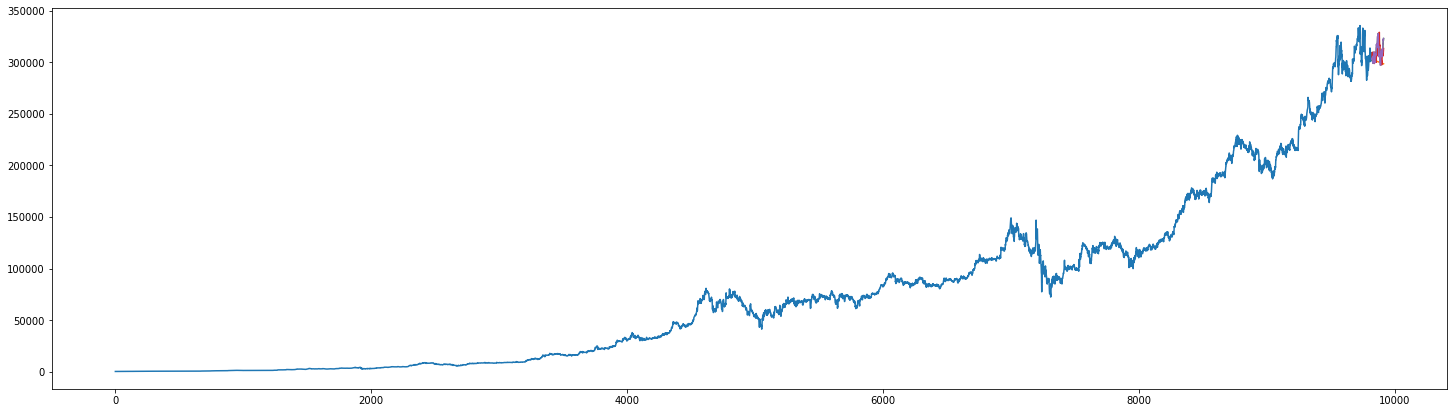

In [136]:
plot_predict(ts_berkshire, df_arima_berkshire, 90)

## Cálculo do Erro - Ações da Berkshire

In [137]:
list_result = []
for m in ['arima_direct', 'arima_1step', 'arima_10step']:

  dict_result = gerenerate_metric_results(df_arima_berkshire['real'], df_arima_berkshire[m])
  dict_result['name'] = m
  list_result.append(dict_result)

pd.DataFrame(list_result)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,name
0,1.387675e+08,11779.963675,2.928979,9225.458349,41587.187503,1.752223,46.666667,arima_direct
1,6.666994e+06,2582.052360,0.643989,1995.984548,1.022632,0.129376,52.222222,arima_1step
2,7.632840e+07,8736.612477,2.368756,7351.132854,12.004977,1.554493,52.222222,arima_10step


##Definição da MLP - Berkshire##

In [138]:
lag_size = 12
test_size = 90

df_lag_berkshire = create_windowing(ts_berkshire, lag_size)
df_lagged = df_lag_berkshire.copy()

Separação do conjuto de treinamento e teste

In [139]:
X_train = df_lagged.iloc[0:-test_size].drop(columns=['actual'])
y_train = df_lagged.iloc[0:-test_size]['actual'].values.reshape(-1, 1)

X_test = df_lagged.iloc[-test_size:].drop(columns=['actual'])
y_test = df_lagged.iloc[-test_size:]['actual'].values.reshape(-1, 1)

Normalização dos dados de treinamento

In [140]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(X_train)
scaler_y.fit(y_train)

MinMaxScaler()

In [141]:
x_train_norm = scaler_x.transform(X_train)

y_train_norm = scaler_y.transform(y_train).flatten()

x_test_norm = scaler_x.transform(X_test)

In [142]:
from sklearn.neural_network import MLPRegressor

model_mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic'
            , solver='adam', learning_rate_init=0.01, 
             power_t=0.5, max_iter=100000, random_state=None,
             tol=0.0001 )

model_mlp.fit(x_train_norm, y_train_norm)

MLPRegressor(activation='logistic', learning_rate_init=0.01, max_iter=100000)

In [143]:
from sklearn.svm import SVR

model_svr = SVR(C=1000, epsilon=0.001)
model_svr.fit(x_train_norm, y_train_norm)

SVR(C=1000, epsilon=0.001)

In [144]:
prevs_svr_1step = model_svr.predict(x_test_norm)

In [145]:
prevs_mlp_1step = model_mlp.predict(x_test_norm)

In [146]:
prevs_mlp_1step = scaler_y.inverse_transform(prevs_mlp_1step.reshape(-1, 1)).flatten()
prevs_svr_1step = scaler_y.inverse_transform(prevs_svr_1step.reshape(-1, 1)).flatten()

In [147]:
df_arima_berkshire['prevs_mlp_1step'] = prevs_mlp_1step
df_arima_berkshire['prevs_svr_1step'] = prevs_svr_1step

In [148]:
list_result = []
for m in ['arima_direct', 'arima_1step', 'arima_10step', 'prevs_mlp_1step', 'prevs_svr_1step']:

  dict_result = gerenerate_metric_results(df_arima_berkshire['real'], df_arima_berkshire[m])
  dict_result['name'] = m
  list_result.append(dict_result)

pd.DataFrame(list_result)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,name
0,1.387675e+08,11779.963675,2.928979,9225.458349,41587.187503,1.752223,46.666667,arima_direct
1,6.666994e+06,2582.052360,0.643989,1995.984548,1.022632,0.129376,52.222222,arima_1step
2,7.632840e+07,8736.612477,2.368756,7351.132854,12.004977,1.554493,52.222222,arima_10step
3,4.547346e+07,6743.401156,1.810685,5665.623215,79.294578,0.990529,58.888889,prevs_mlp_1step
4,7.244566e+06,2691.573214,0.684148,2119.996777,0.966970,0.148280,54.444444,prevs_svr_1step


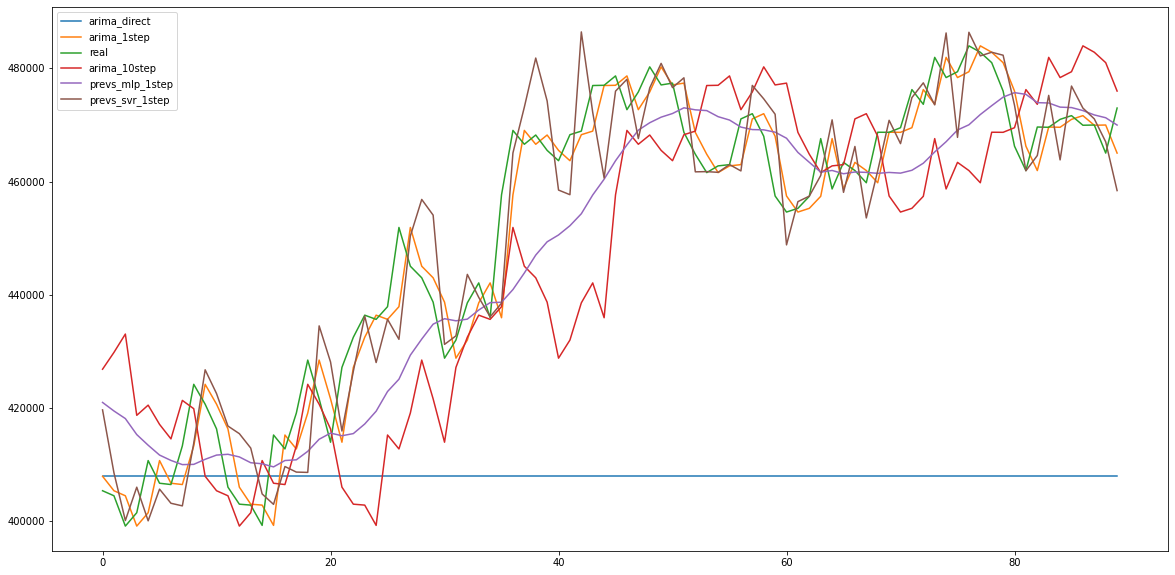

In [53]:
df_arima_berkshire.plot()

## Análise uma série temporal do pydataset - 'UKDriverDeaths'

In [54]:
timeseries_titles = ['AirPassengers', 'nottem', 'ambientNOxCH', 'acme', 'sunspot.year', 'UKDriverDeaths', 
                    'USAccDeaths', 'UKgas', 'JohnsonJohnson', 'Nile', 'LakeHuron', 'austres', 
                    'lynx', 'deaths', 'drivers']
                    
df_ukdrivers = data('UKDriverDeaths')

print(len(timeseries_titles))

15


In [55]:
data('UKDriverDeaths', show_doc=True )

UKDriverDeaths

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

##  Road Casualties in Great Britain 1969–84

### Description

`UKDriverDeaths` is a time series giving the monthly totals of car drivers in
Great Britain killed or seriously injured Jan 1969 to Dec 1984. Compulsory
wearing of seat belts was introduced on 31 Jan 1983.

`Seatbelts` is more information on the same problem.

### Usage

    UKDriverDeaths
    Seatbelts

### Format

`Seatbelts` is a multiple time series, with columns

`DriversKilled`

car drivers killed.

`drivers`

same as `UKDriverDeaths`.

`front`

front-seat passengers killed or seriously injured.

`rear`

rear-seat passengers killed or seriously injured.

`kms`

distance driven.

`PetrolPrice`

petrol price.

`VanKilled`

number of van (‘light goods vehicle’) drivers.

`law`

0/1: was the law in effect that month?

### Source

Harvey, A.C. (1989) _Forecasting, Structural Time Series Models and the Kalman
Filter._ Ca

In [56]:
df_ukdrivers['date'] = pd.date_range(start ='1969-01-01', end='1985-01-01', freq='M')

In [57]:
df_ukdrivers.set_index('date', inplace=True)

**Análise**:

No gráfico de mortes mensais no Reino Unido não há tendência, mas aparentemente existe uma sazonalidade e ciclo. Confirmado nos gráficos de média mensal.

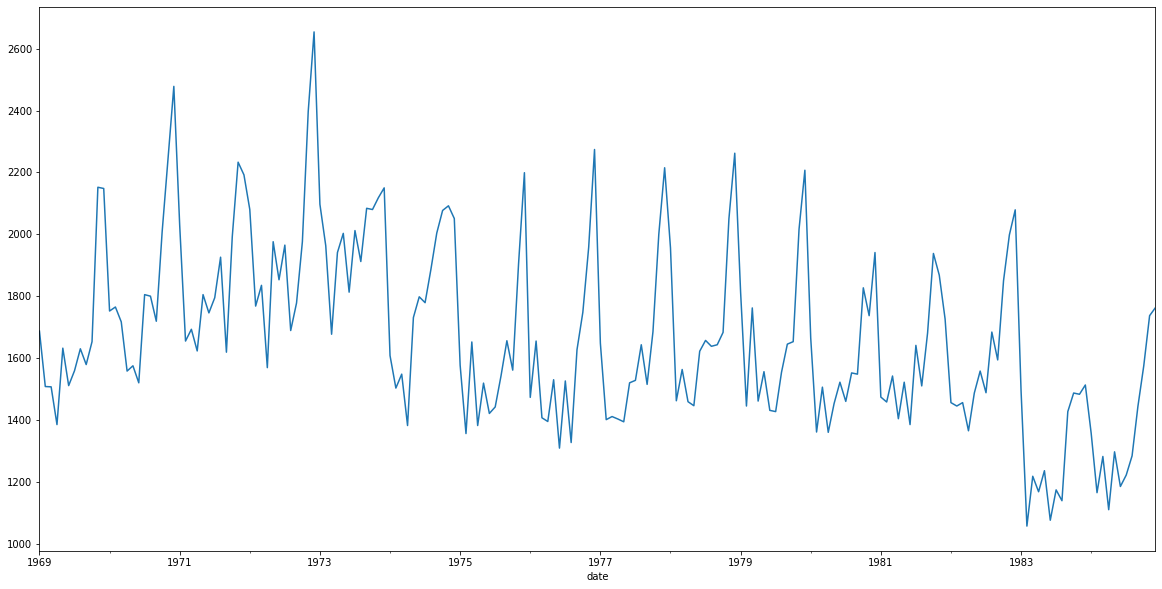

In [58]:
df_ukdrivers['UKDriverDeaths'].plot()

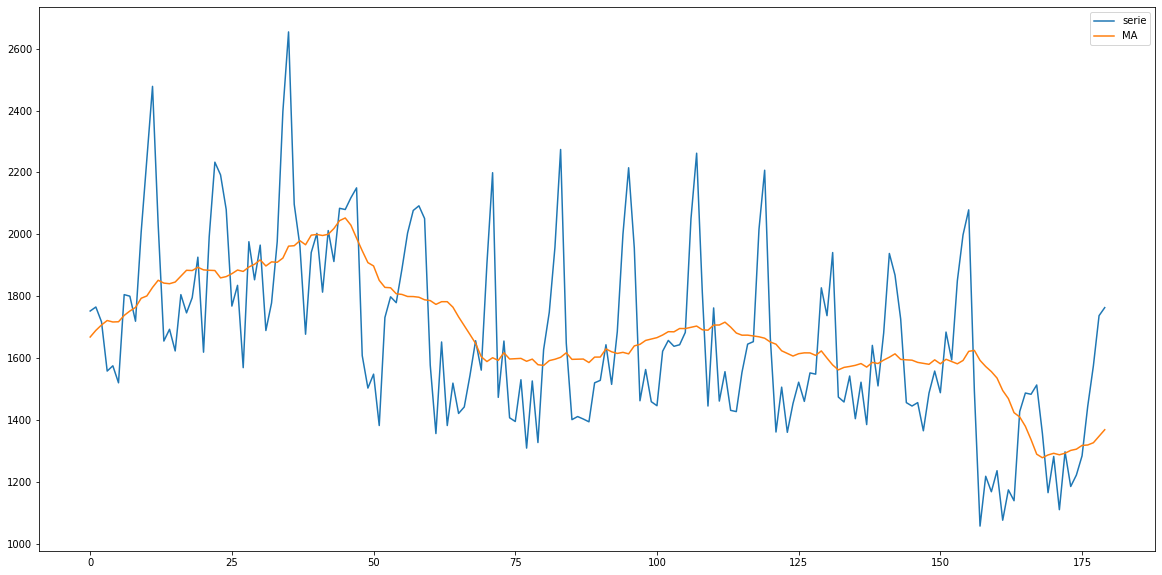

In [59]:
ts = df_ukdrivers['UKDriverDeaths']
ma_size=12
show_trend(ts, ma_size)

**Análise**:

No gráfico de correlação acumulada, aparentemente existe uma correlação muito forte a cada 12 meses, indicando uma sazonalidade.

Na análise parcial da correlação, podemos ver que o gráfico apresenta uma característica de sazonalidade também, mas com correlação mais fraca nos depois de 12 e 24 meses.

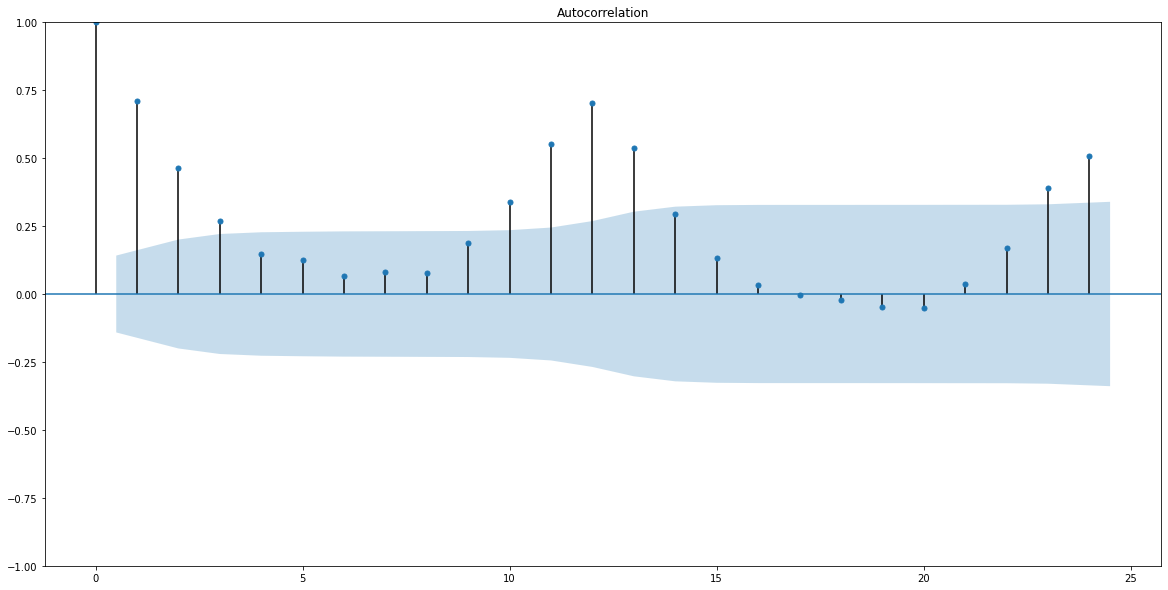

In [60]:
sm.graphics.tsa.plot_acf(df_ukdrivers['UKDriverDeaths'].values.squeeze(), lags=24)

plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


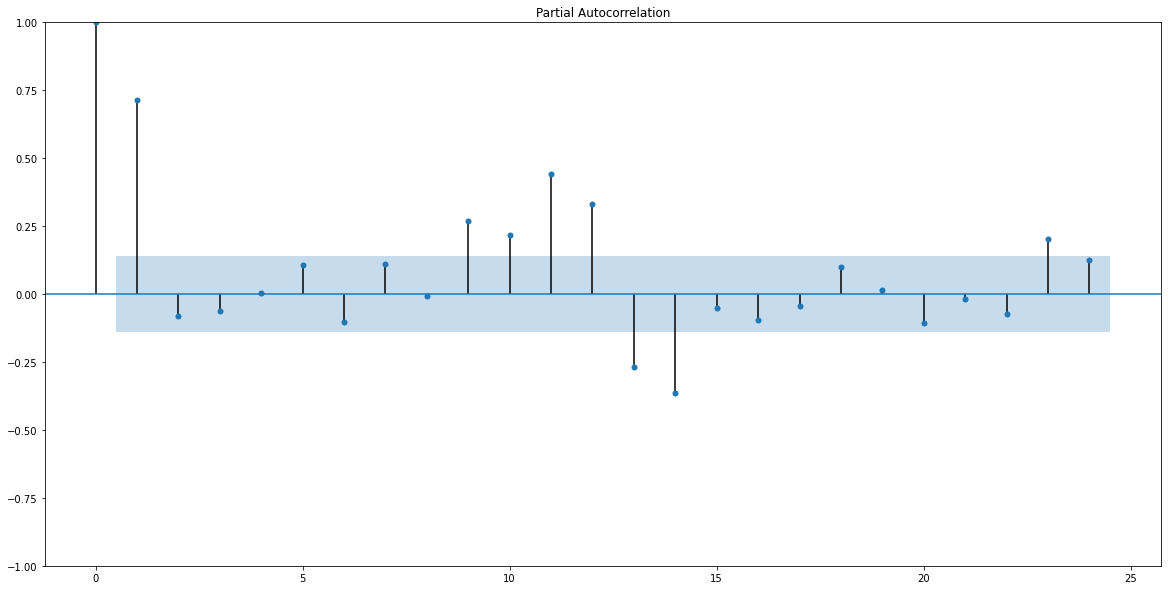

In [61]:
sm.graphics.tsa.plot_pacf(df_ukdrivers['UKDriverDeaths'].values.squeeze(), lags=24)

plt.show()

**Análise com função KPSSTest - UKDriverDeaths**

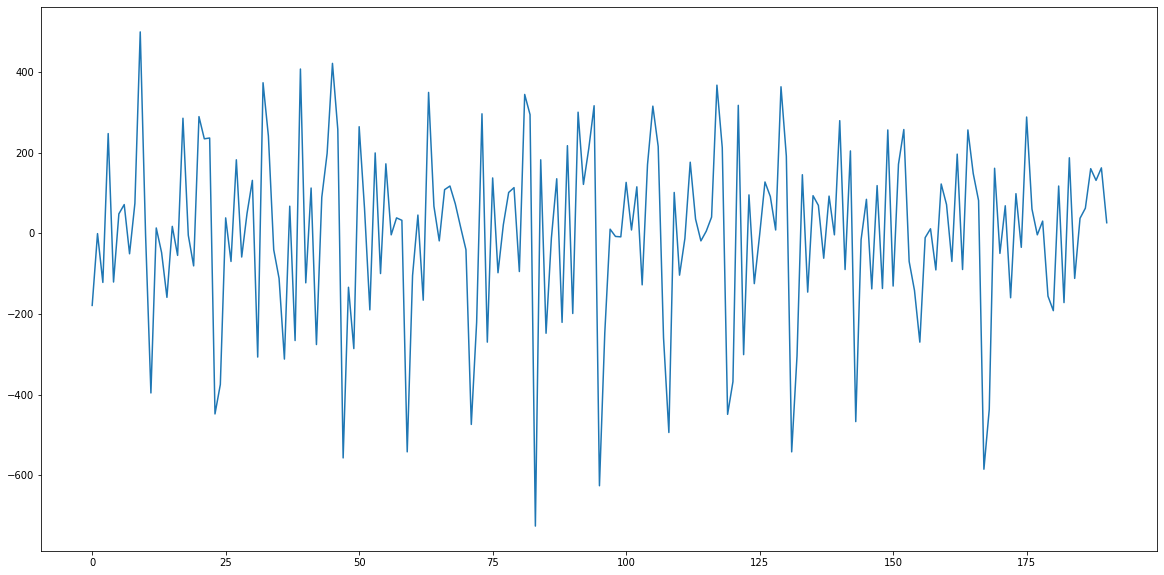

In [62]:
diff_ukdrivers = difference(df_ukdrivers['UKDriverDeaths']) # ou ts.diff()
diff_ukdrivers.plot()
plt.show()

In [63]:
kps.should_diff(df_ukdrivers['UKDriverDeaths'])

(0.01, True)

**Análise**

Plot do ACF para o primeiro diff da série UKDriverDeaths. 

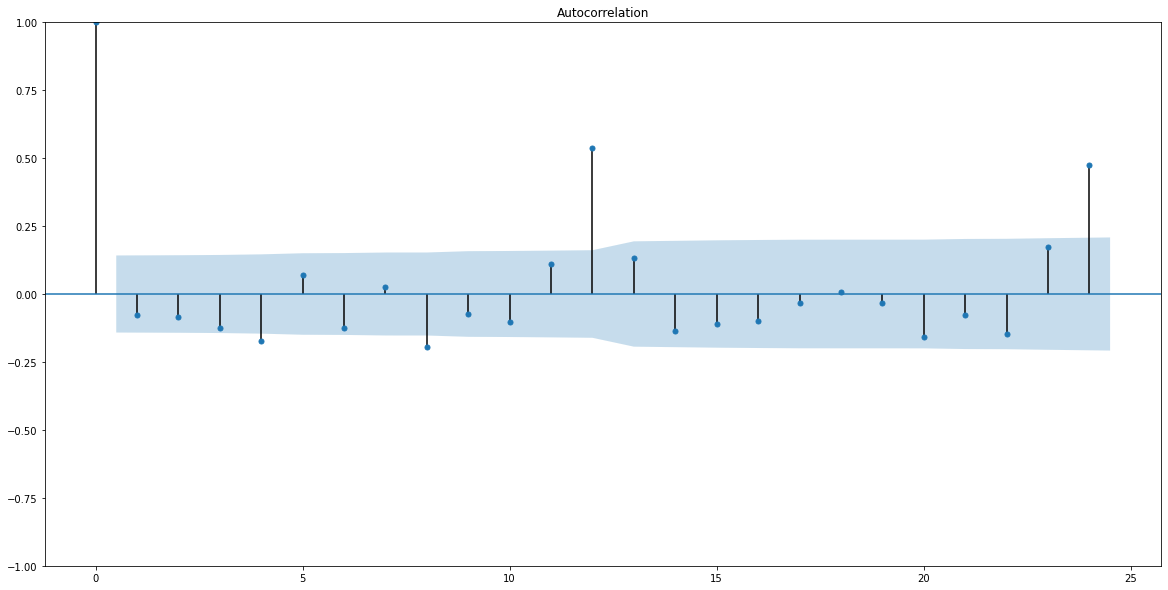

In [64]:
sm.graphics.tsa.plot_acf(diff_ukdrivers, lags=24)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


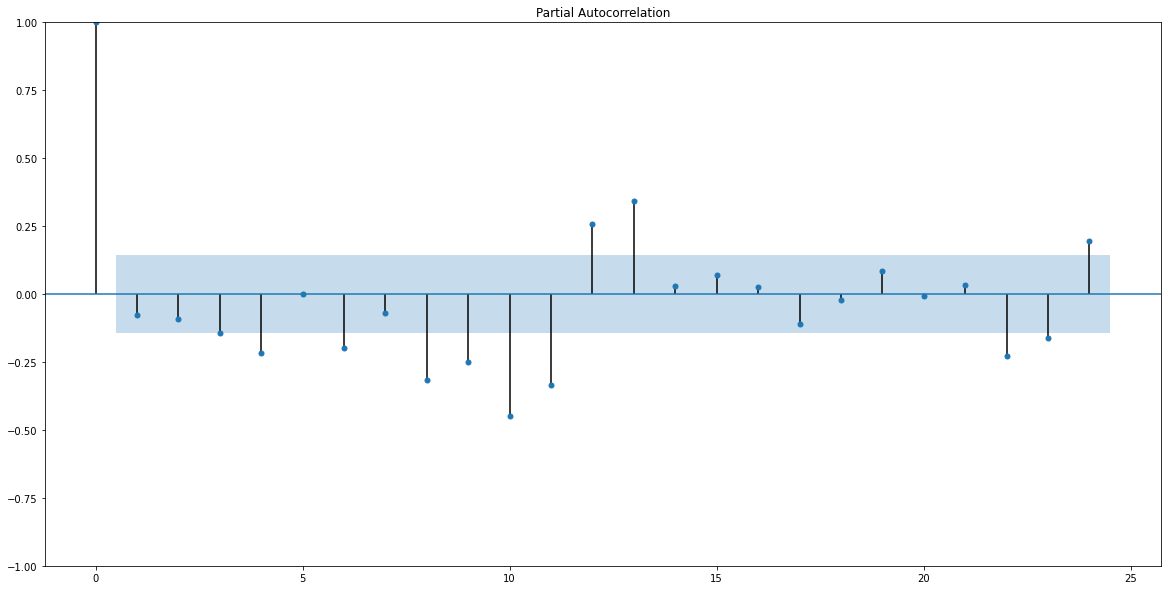

In [65]:
sm.graphics.tsa.plot_pacf(diff_ukdrivers, lags=24)
plt.show()

In [66]:
kps.should_diff(diff_ukdrivers)

(0.1, False)

**Anáise**

De acordo com a função de KPSSTest, o dados de acidentes do dataset UKDriverDeaths precisaria da função diff, mas depois do primeiro diff, o KPSSTest já indicou False no teste.

##Criação do modelo com auto_arima - UKDriverDeaths## 

In [67]:
auto_arima(df_ukdrivers['UKDriverDeaths'], # X=None,
           start_p=2, d=None, start_q=2, 
           max_p=5, max_d=2, max_q=5, start_P=1, D=None,
           start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=12, trace=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2607.707, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2538.987, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2563.110, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2605.707, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2608.535, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2528.667, Time=0.51 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2523.079, Time=0.63 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2520.319, Time=0.27 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2564.471, Time=0.19 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2522.829, Time=0.61 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2557.524, Time=0.49 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=2520.990, Time=0.72 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2530.955, Time=0.24 sec
 ARIMA(2,1,0)(1,0,1)[12]

ARIMA(maxiter=10, order=(0, 1, 0), scoring_args={},
      seasonal_order=(1, 0, 2, 12), suppress_warnings=True,
      with_intercept=False)

## Predict com auto_arima e 1 step and direct

In [68]:
df_arima_ukdrivers = arima_fit_predict(df_ukdrivers['UKDriverDeaths'], 12, 28)

training shape (164,)
test shape (28,)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2154.032, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2232.950, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2169.136, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2188.922, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2230.950, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2175.145, Time=0.26 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2161.230, Time=0.31 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2157.420, Time=0.72 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=2154.785, Time=0.63 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2207.150, Time=0.13 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2173.860, Time=0.68 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2159.003, Time=0.66 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=2156.701, Time=0.77 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=2155

100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


##Predict com auto_arima e 10 steps.#

In [69]:
arima_hsteps_uk = arima_horizon_fit_predict(df_ukdrivers['UKDriverDeaths'], 12, 28, 10)
df_arima_ukdrivers['arima_10step'] = arima_hsteps_uk['arima_10step'].values

training shape (155,)
test shape (37,)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2042.835, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2115.528, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2053.714, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2073.538, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2113.533, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2062.468, Time=0.23 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2048.565, Time=0.27 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2045.565, Time=0.70 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=2044.305, Time=0.63 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2094.160, Time=0.12 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2060.842, Time=0.55 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2046.491, Time=0.62 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=2044.848, Time=0.70 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=2046

  0%|          | 0/37 [00:00<?, ?it/s]

fim do treino 155


  3%|▎         | 1/37 [00:00<00:10,  3.41it/s]

fim do treino 156


  5%|▌         | 2/37 [00:00<00:10,  3.39it/s]

fim do treino 157


  8%|▊         | 3/37 [00:00<00:10,  3.27it/s]

fim do treino 158


 11%|█         | 4/37 [00:01<00:10,  3.09it/s]

fim do treino 159


 14%|█▎        | 5/37 [00:01<00:09,  3.20it/s]

fim do treino 160


 16%|█▌        | 6/37 [00:01<00:09,  3.23it/s]

fim do treino 161


 19%|█▉        | 7/37 [00:02<00:09,  3.30it/s]

fim do treino 162


 22%|██▏       | 8/37 [00:02<00:08,  3.28it/s]

fim do treino 163


 24%|██▍       | 9/37 [00:02<00:08,  3.19it/s]

fim do treino 164


 27%|██▋       | 10/37 [00:03<00:08,  3.22it/s]

fim do treino 165


 30%|██▉       | 11/37 [00:03<00:08,  3.22it/s]

fim do treino 166


 32%|███▏      | 12/37 [00:03<00:07,  3.20it/s]

fim do treino 167


 35%|███▌      | 13/37 [00:04<00:07,  3.21it/s]

fim do treino 168


 38%|███▊      | 14/37 [00:04<00:07,  3.15it/s]

fim do treino 169


 41%|████      | 15/37 [00:04<00:07,  3.09it/s]

fim do treino 170


 43%|████▎     | 16/37 [00:04<00:06,  3.16it/s]

fim do treino 171


 46%|████▌     | 17/37 [00:05<00:06,  3.14it/s]

fim do treino 172


 49%|████▊     | 18/37 [00:05<00:06,  3.15it/s]

fim do treino 173


 51%|█████▏    | 19/37 [00:05<00:05,  3.17it/s]

fim do treino 174


 54%|█████▍    | 20/37 [00:06<00:05,  3.13it/s]

fim do treino 175


 57%|█████▋    | 21/37 [00:06<00:05,  3.04it/s]

fim do treino 176


 59%|█████▉    | 22/37 [00:06<00:04,  3.04it/s]

fim do treino 177


 62%|██████▏   | 23/37 [00:07<00:04,  3.08it/s]

fim do treino 178


 65%|██████▍   | 24/37 [00:07<00:04,  3.07it/s]

fim do treino 179


 68%|██████▊   | 25/37 [00:07<00:03,  3.05it/s]

fim do treino 180


 70%|███████   | 26/37 [00:08<00:03,  3.10it/s]

fim do treino 181


 73%|███████▎  | 27/37 [00:08<00:03,  3.08it/s]

fim do treino 182


 76%|███████▌  | 28/37 [00:08<00:02,  3.03it/s]

fim do treino 183


 78%|███████▊  | 29/37 [00:09<00:02,  3.08it/s]

fim do treino 184


 81%|████████  | 30/37 [00:09<00:02,  3.05it/s]

fim do treino 185


 84%|████████▍ | 31/37 [00:09<00:01,  3.01it/s]

fim do treino 186


 86%|████████▋ | 32/37 [00:10<00:01,  3.03it/s]

fim do treino 187


 89%|████████▉ | 33/37 [00:10<00:01,  2.97it/s]

fim do treino 188


 92%|█████████▏| 34/37 [00:10<00:01,  2.96it/s]

fim do treino 189


 95%|█████████▍| 35/37 [00:11<00:00,  3.01it/s]

fim do treino 190


 97%|█████████▋| 36/37 [00:11<00:00,  2.95it/s]

fim do treino 191


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


## Plot das previões com auto_arima: Direct, 1 step, 10 steps e real.

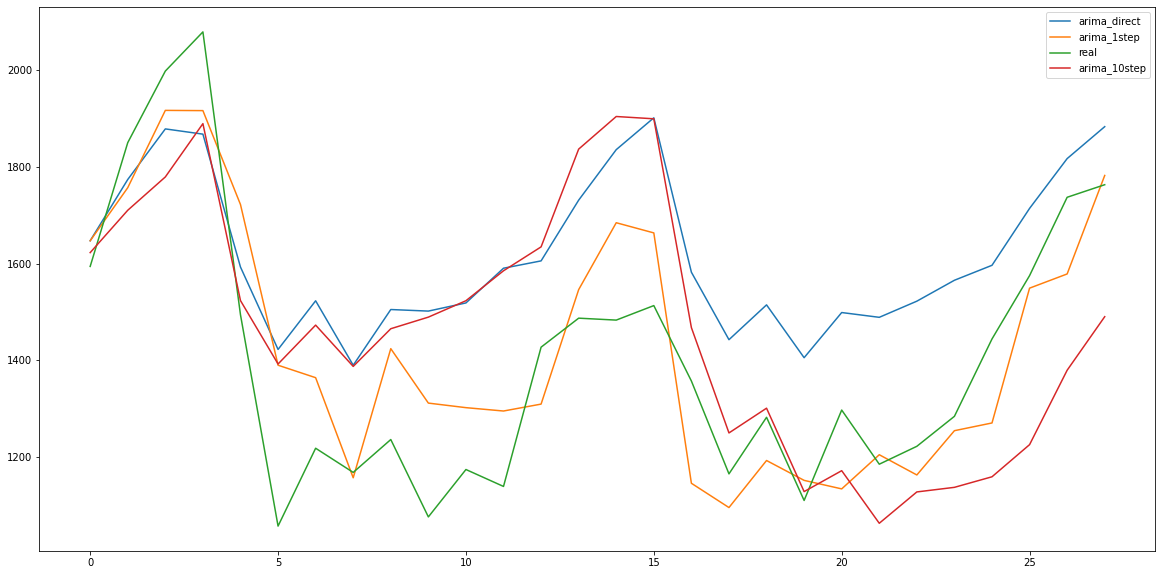

In [70]:
df_arima_ukdrivers.plot()
plt.show()

In [71]:
df_arima_ukdrivers.head()

,arima_direct,arima_1step,real,arima_10step
0,1647.067318,1647.067318,1594,1622.541527
1,1773.800280,1756.854602,1850,1710.168409
2,1878.409270,1916.719736,1998,1779.060289
3,1867.572143,1916.220783,2079,1889.312777
4,1592.733404,1721.995825,1494,1523.367674


In [72]:
df_arima_ukdrivers.shape

(28, 4)

##Plot das previões realizadas junto com os dados reais através do tempo.

(164,) (164,) (28,) (28,)


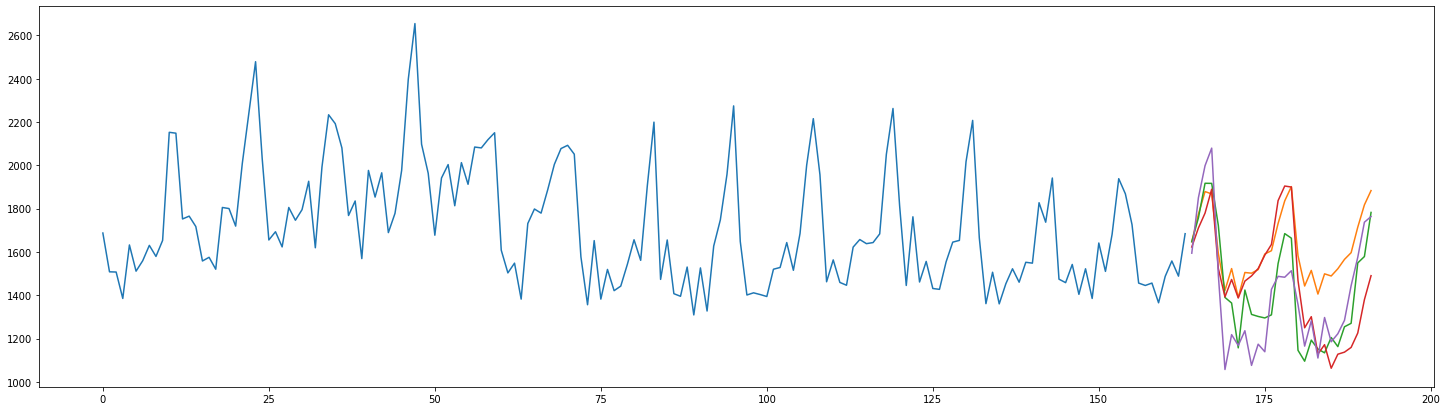

In [73]:
plot_predict(df_ukdrivers['UKDriverDeaths'], df_arima_ukdrivers, 28)

##Cálculo do Erro   - UKDriversDeath##

In [74]:
list_result = []
for m in ['arima_direct', 'arima_1step', 'arima_10step']:

  dict_result = gerenerate_metric_results(df_arima_ukdrivers['real'], df_arima_ukdrivers[m])
  dict_result['name'] = m
  list_result.append(dict_result)

pd.DataFrame(list_result)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,name
0,68914.319023,262.515369,18.607111,239.755170,4.951902,1.001840,85.714286,arima_direct
1,20984.640595,144.860763,9.102848,121.589842,0.728353,0.335540,67.857143,arima_1step
2,66186.024977,257.266447,16.294891,221.554121,3.227909,1.001163,82.142857,arima_10step


##Definição da MLP - UKDriversDeath##

In [75]:
lag_size = 12
test_size = 28

df_lag_ukdrivers = create_windowing(df_ukdrivers['UKDriverDeaths'], lag_size)
df_lagged_uk = df_lag_ukdrivers.copy()

Separação do conjuto de treinamento e teste

In [76]:
X_train_uk = df_lagged_uk.iloc[0:-test_size].drop(columns=['actual'])
y_train_uk = df_lagged_uk.iloc[0:-test_size]['actual'].values.reshape(-1, 1)

X_test_uk = df_lagged_uk.iloc[-test_size:].drop(columns=['actual'])
y_test_uk = df_lagged_uk.iloc[-test_size:]['actual'].values.reshape(-1, 1)

Normalização dos dados de treinamento

In [77]:
from sklearn.preprocessing import MinMaxScaler
scaler_x_uk = MinMaxScaler()
scaler_y_uk = MinMaxScaler()

scaler_x_uk.fit(X_train_uk)
scaler_y_uk.fit(y_train_uk)

MinMaxScaler()

In [78]:
x_train_norm_uk = scaler_x_uk.transform(X_train_uk)

y_train_norm_uk = scaler_y_uk.transform(y_train_uk).flatten()

x_test_norm_uk = scaler_x_uk.transform(X_test_uk)

In [79]:
from sklearn.neural_network import MLPRegressor

model_mlp_uk = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic'
            , solver='adam', learning_rate_init=0.01, 
             power_t=0.5, max_iter=100000, random_state=None,
             tol=0.0001 )

model_mlp_uk.fit(x_train_norm_uk, y_train_norm_uk)

MLPRegressor(activation='logistic', learning_rate_init=0.01, max_iter=100000)

In [80]:
from sklearn.svm import SVR

model_svr_uk = SVR(C=1000, epsilon=0.001)
model_svr_uk.fit(x_train_norm_uk, y_train_norm_uk)

SVR(C=1000, epsilon=0.001)

In [81]:
prevs_svr_1step_uk = model_svr_uk.predict(x_test_norm_uk)

In [82]:
prevs_mlp_1step_uk = model_mlp_uk.predict(x_test_norm_uk)

In [83]:
prevs_mlp_1step_uk = scaler_y_uk.inverse_transform(prevs_mlp_1step_uk.reshape(-1, 1)).flatten()
prevs_svr_1step_uk = scaler_y_uk.inverse_transform(prevs_svr_1step_uk.reshape(-1, 1)).flatten()

In [84]:
df_arima_ukdrivers['prevs_mlp_1step'] = prevs_mlp_1step_uk
df_arima_ukdrivers['prevs_svr_1step'] = prevs_svr_1step_uk

In [85]:
list_result = []
for m in ['arima_direct', 'arima_1step', 'arima_10step', 'prevs_mlp_1step', 'prevs_svr_1step']:

  dict_result = gerenerate_metric_results(df_arima_ukdrivers['real'], df_arima_ukdrivers[m])
  dict_result['name'] = m
  list_result.append(dict_result)

pd.DataFrame(list_result)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,name
0,68914.319023,262.515369,18.607111,239.755170,4.951902,1.001840,85.714286,arima_direct
1,20984.640595,144.860763,9.102848,121.589842,0.728353,0.335540,67.857143,arima_1step
2,66186.024977,257.266447,16.294891,221.554121,3.227909,1.001163,82.142857,arima_10step
3,39321.645506,198.296862,11.923741,163.243420,3.786795,0.872237,57.142857,prevs_mlp_1step
4,147743.144684,384.373704,26.545119,348.313447,5.318596,1.155170,50.000000,prevs_svr_1step


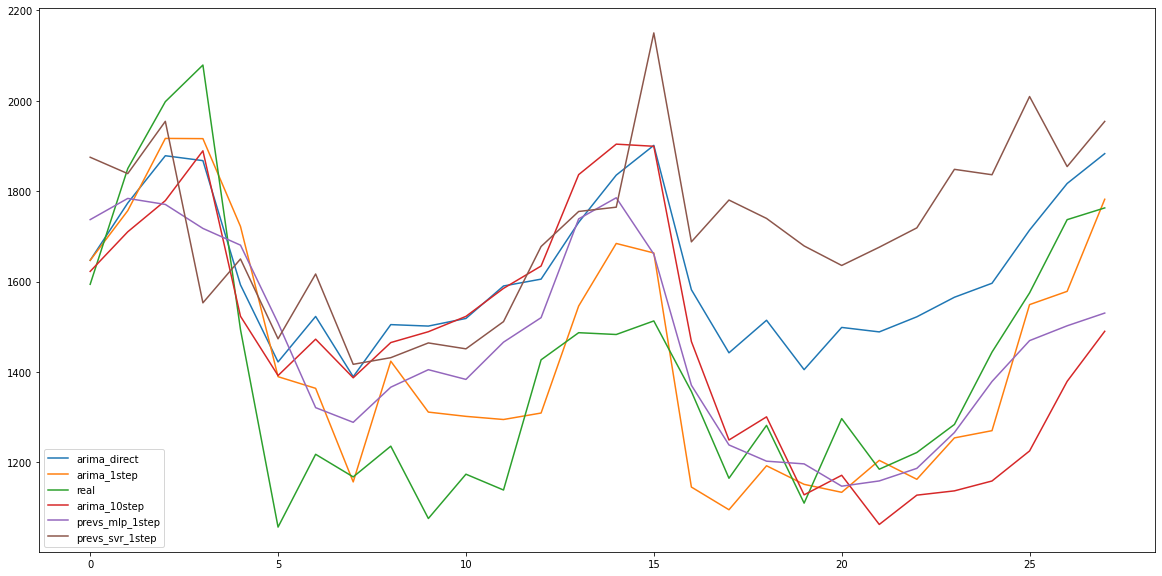

In [86]:
df_arima_ukdrivers.plot()

## Análise da série temporal "sem_nome"

In [87]:
from google.colab import drive
drive.mount('/content/gdrive')
df_sem_nome = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Dados/sem_nome.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [88]:
#df_sem_nome = pd.read_csv('sem_nome.csv')
#df_sem_nome
df_sem_nome.shape

(1000, 2)

**Análise**:

Na plotagem de todos os dados temporais, aparentemente não há uma tendência, mesmo fazendo um corte dos últimos 200 dados, difícil analisar se existe uma sazonalidade e ciclos.

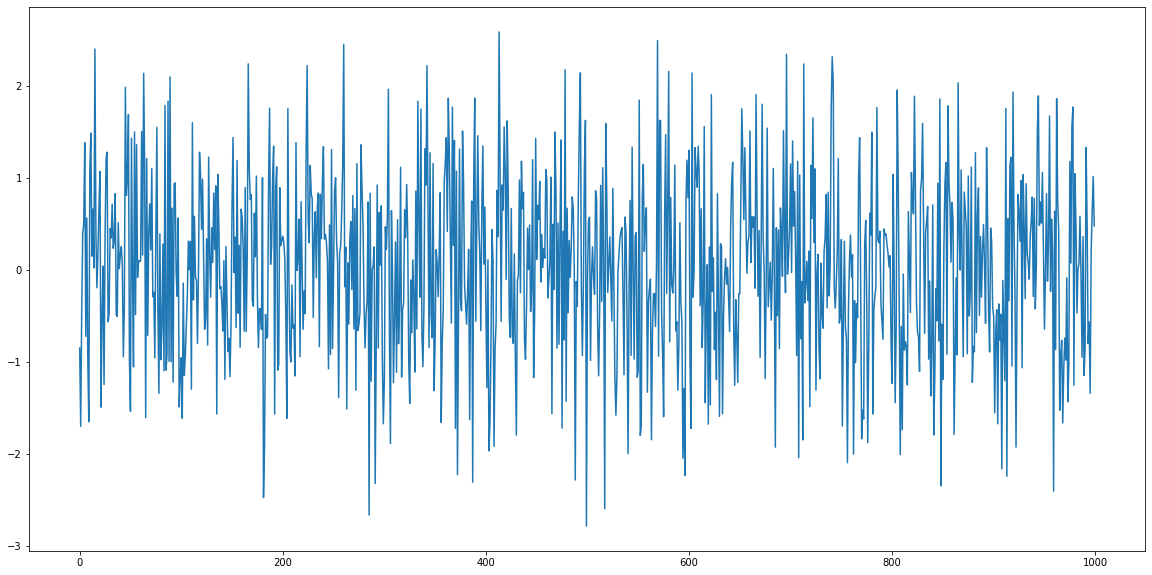

In [89]:
df_sem_nome['actual'].plot()

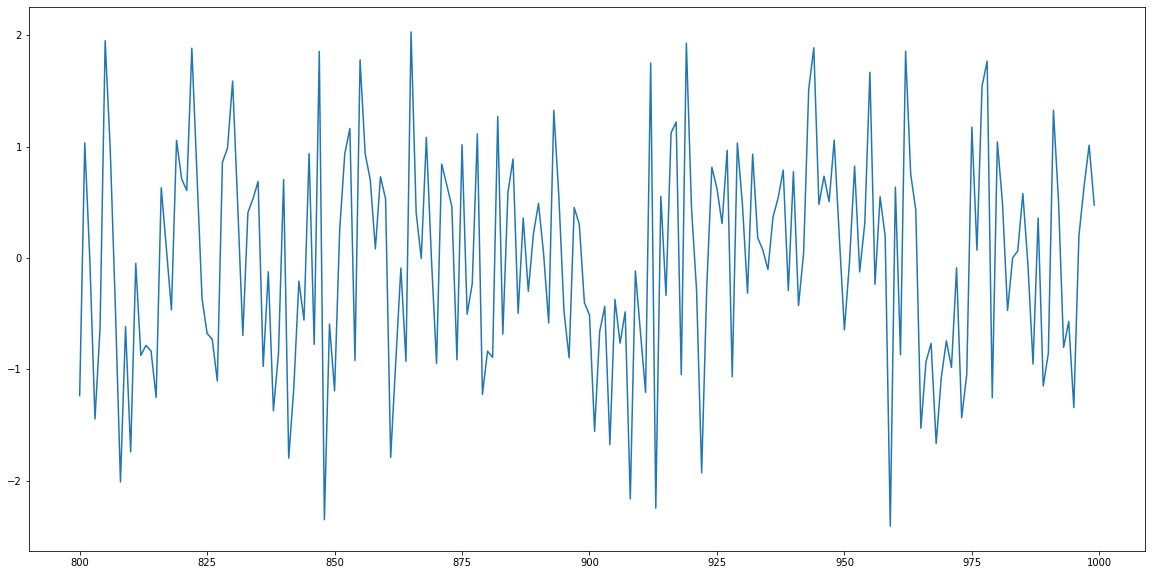

In [90]:
df_sem_nome['actual'].iloc[-200:].plot()

**Análise**:


Tanto no gráfico de correlação acumulada quanto na correlação parcial, não existe correlação entre os dados, nem mesmo no t-1. Média móvel bem próxima de zero indicando um caraterística de "Ruído Branco".

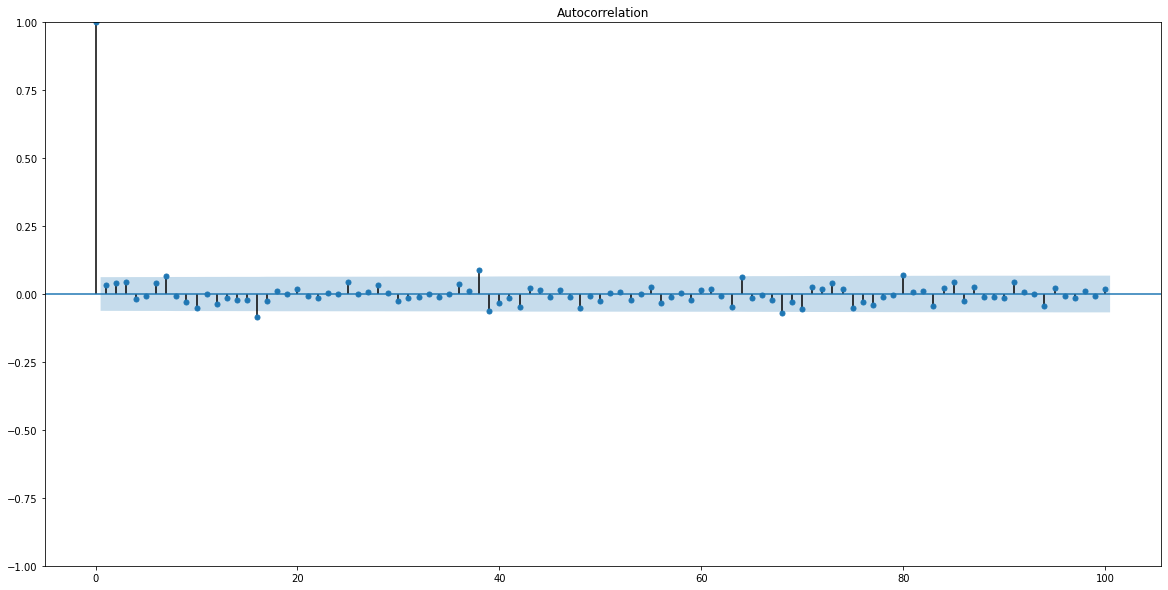

In [91]:
sm.graphics.tsa.plot_acf(df_sem_nome['actual'].values.squeeze(), lags=100)

plt.show()

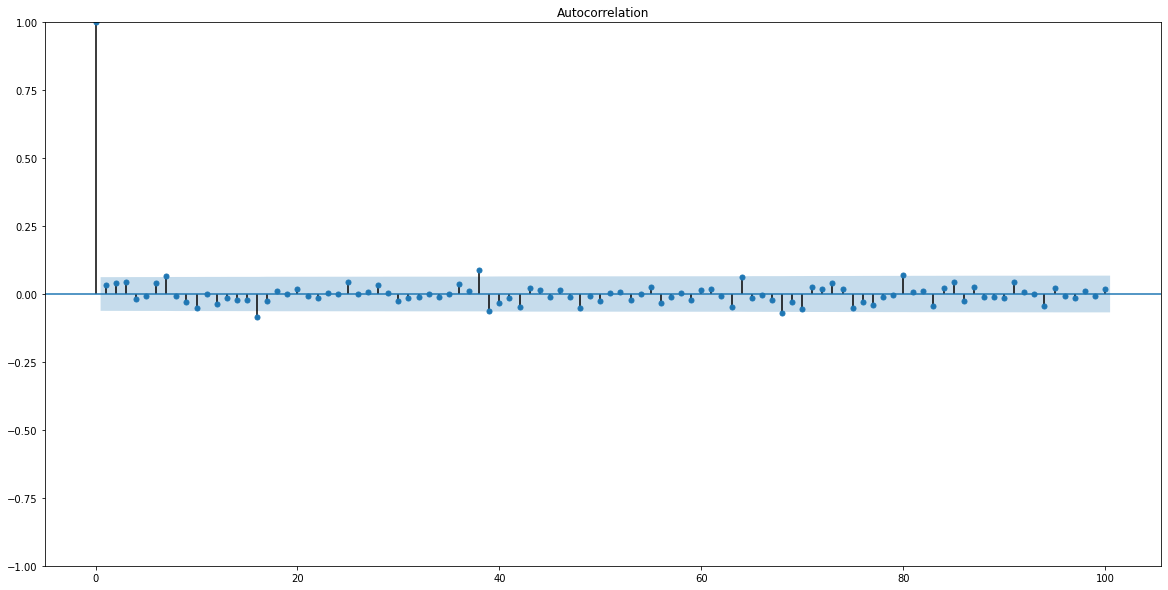

In [92]:
sm.graphics.tsa.plot_acf(df_sem_nome['actual'].values.squeeze(), lags=100)

plt.show()

**Análise com função KPSSTest - sem_nome dataset**

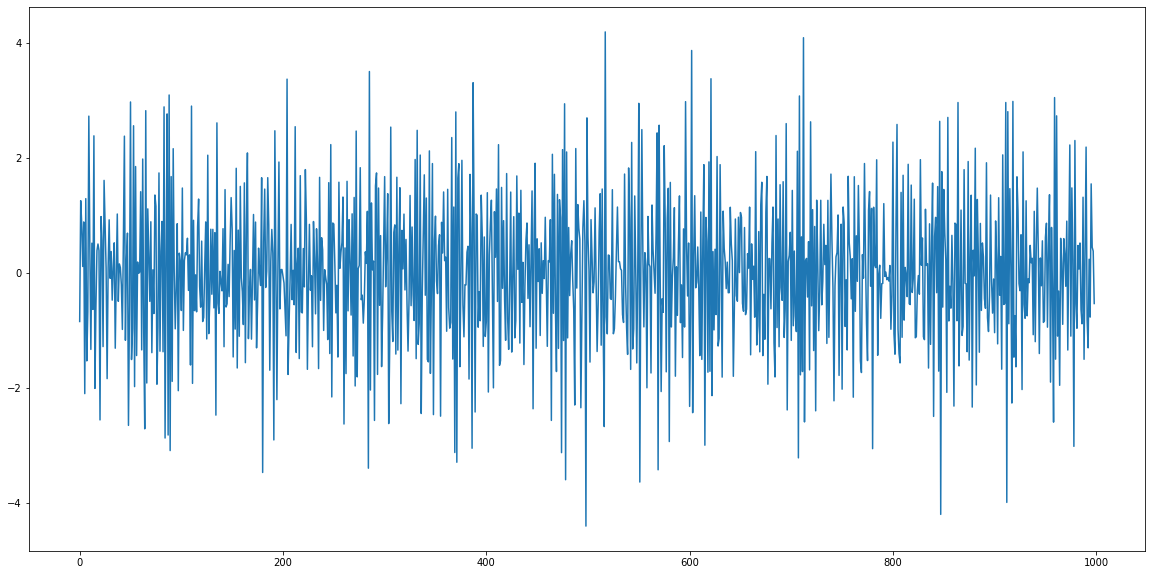

In [93]:
diff_semnome = difference(df_sem_nome['actual']) # ou ts.diff()
diff_semnome.plot()
plt.show()

In [94]:
kps.should_diff(df_sem_nome['actual'])

(0.1, False)

**Análise**

Verificando o KPSSTest para o dataset sem_nome, podemos ver que não seria necessário fazer o diff no dataset original.

Plotando os gráficos de ACF e PACF para o diff do dataset.

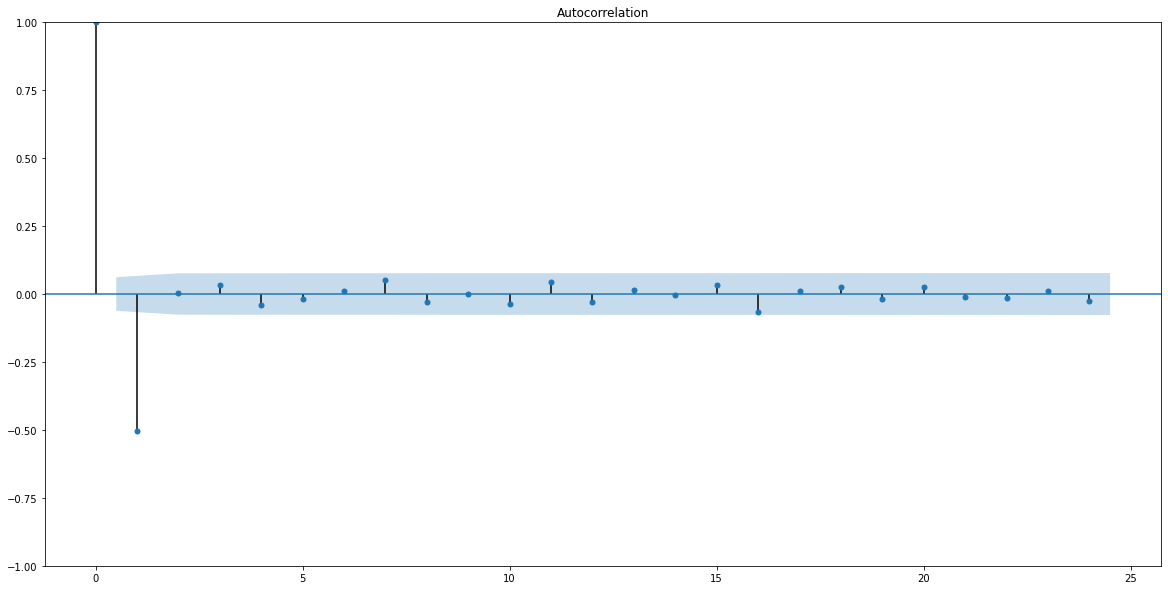

In [95]:
sm.graphics.tsa.plot_acf(diff_semnome, lags=24)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


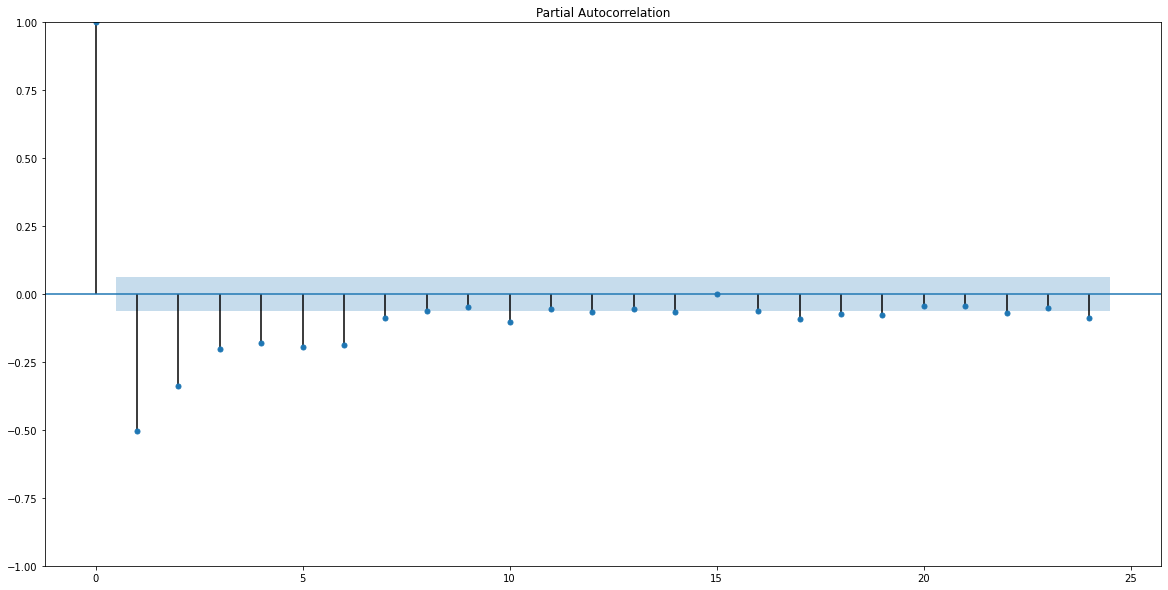

In [96]:
sm.graphics.tsa.plot_pacf(diff_semnome, lags=24)
plt.show()

##Análise ARIMA e ARIMA Sazonal##

In [97]:
white_noise = np.random.normal(size=1000)

In [98]:
c  = 10
ar1 = [1]
peso = 0.5

for i in range(0, len(white_noise)):
  ar1.append(c  + (peso*ar1[i]) + white_noise[i])


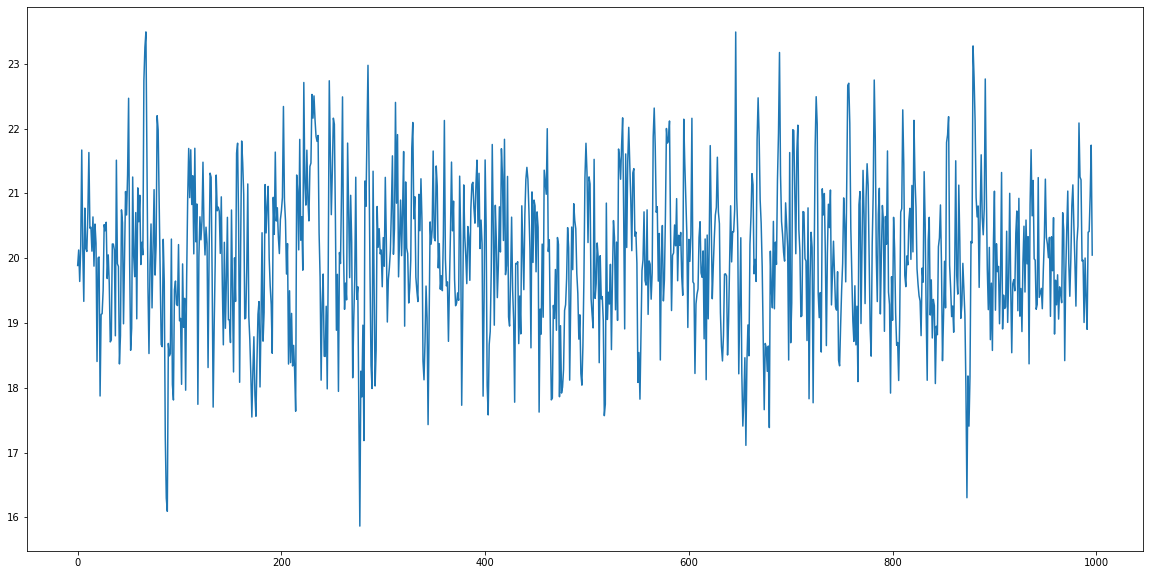

In [99]:
pd.Series(ar1[4:]).plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


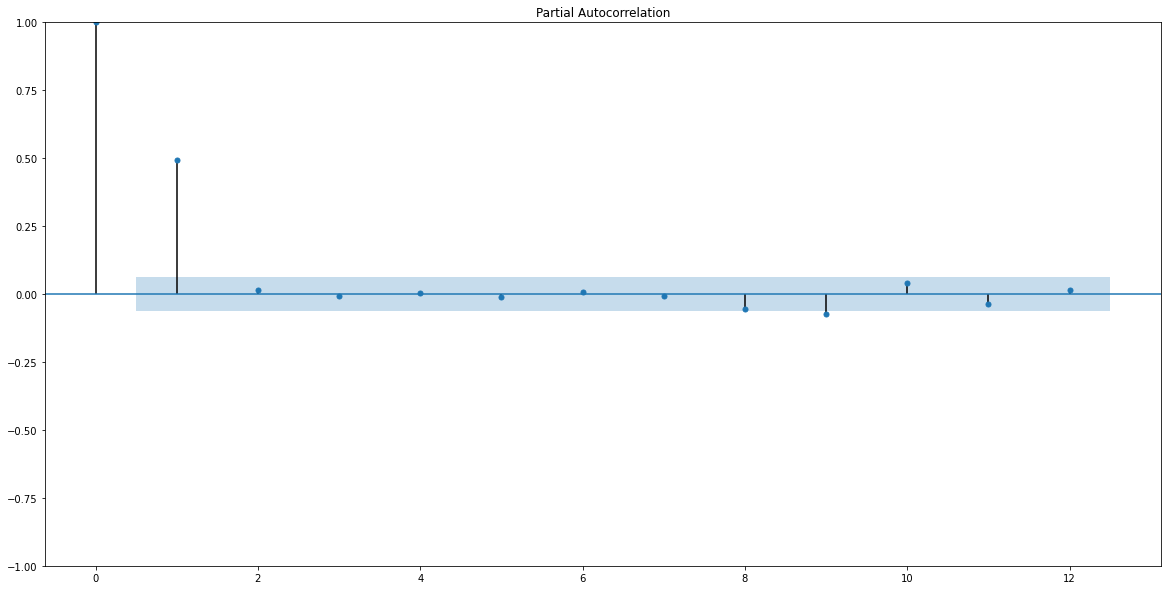

In [100]:
sm.graphics.tsa.plot_pacf(ar1[4:], lags=12)
plt.show()

In [101]:
c  = 10
ar2 = [1, 3]
peso1 = 0.4
peso2 = - 0.5 

for i in range(0, len(white_noise)):
  ar2.append(c  + (peso2*ar2[i]) + (peso1*ar2[i+1]) + white_noise[i])


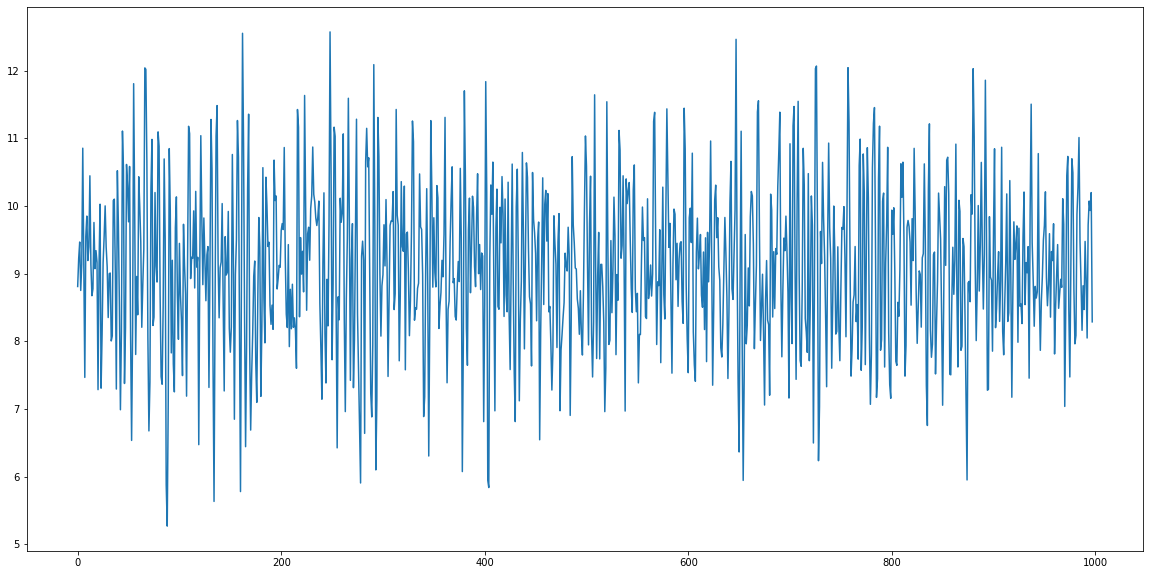

In [102]:
pd.Series(ar2[4:]).plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


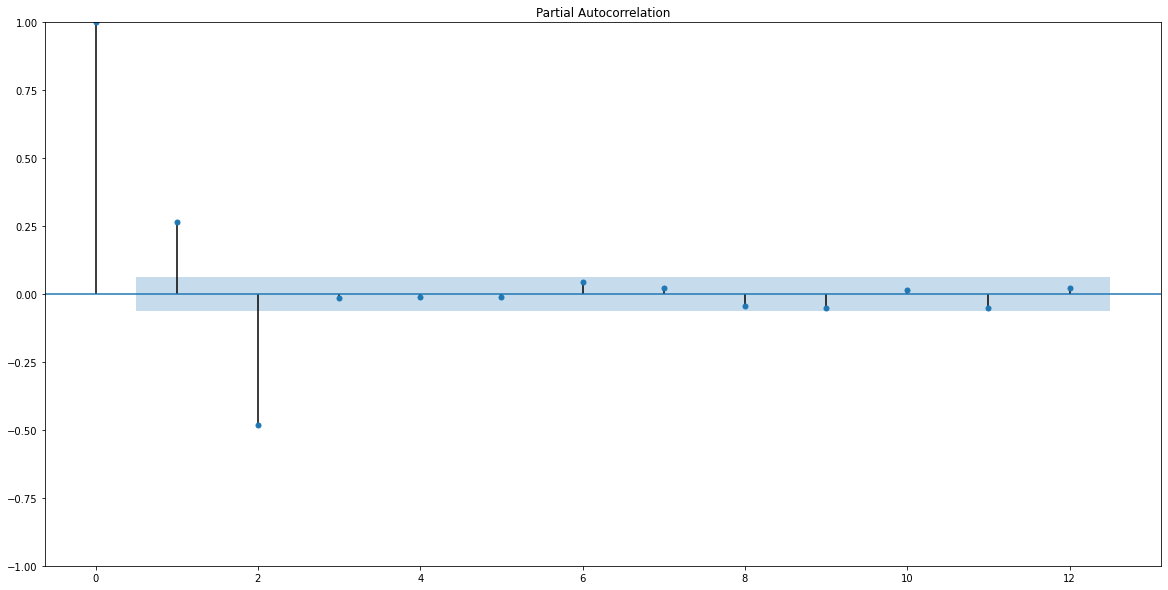

In [103]:
sm.graphics.tsa.plot_pacf(ar2[4:], lags=12)
plt.show()